# Experiments w Kernel Mechanisms for External Memory

## Data

Model a "language modeling" task of predicting the next "word" in terms of a higher-order Markov models.

$$
\begin{align*}
\mathcal{M} &= \{(x^{(t)}, y^{(t)})\}_{t \in [n_m]}\\
x^{(t)} &= (x_1^{(t)}, \ldots, x_l^{(t)})\\
y^{(t)} &= (y_1^{(t)}, \ldots, y_l^{(t)}) = (x_2^{(t)}, \ldots, x_{l+1}^{(t)})\\
\end{align*}
$$

where $x_i^{(t)}$ come from a hidden markov model.
$$
\begin{align*}
x_i^{(t)} &\sim P(\cdot | x_{i-1}^{(t)}, \ldots, x_{i-m}^{(t)})
\end{align*}
$$

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from tqdm.keras import TqdmCallback

import itertools

import sys;sys.path.append('..')
import utils

import tensorflow as tf
from tensorflow.keras import layers

In [104]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Generate Data

In [105]:
n_states = 16
m = 2

state_tuples = list(itertools.product(range(n_states), repeat=m))
len(state_tuples)

256

In [106]:
transition_dict = dict()

for state_tuple in state_tuples:
    next_state = np.random.randint(n_states)
    p = np.zeros(n_states)
    p[next_state] = 1

    transition_dict[state_tuple] = p

In [107]:
def sample_markov_chain(transition_dict, prefix, num_steps):
    states_seq = prefix
    m = len(list(transition_dict.keys())[0])

    for i in range(num_steps-m):
        probabilities = transition_dict[tuple(states_seq[-m:])]
        next_state = np.random.choice(range(n_states), p=probabilities)
        states_seq.append(next_state)
    return states_seq

In [108]:
input_seq_len = 20 # length of input sequences
mem_seq_len = 2*m # length of each memory sequence
mem_size = 32 # number of memory sequences

n_train = 400
n_test = 400

def sample_seqs_dataset(n, input_seq_len):
    seqs = np.array([sample_markov_chain(
        transition_dict, prefix=list(state_tuples[np.random.choice(len(state_tuples))]), num_steps=input_seq_len+1) for _ in range(n)])

    seqs_x = seqs[:, :-1]
    seqs_y = seqs[:, 1:]

    return seqs_x, seqs_y


def sample_mem_dataset(mem_seq_len, mem_size):
    mem_seqs = np.array([sample_markov_chain(
        transition_dict, prefix=list(state_tuples[np.random.choice(len(state_tuples))]), num_steps=mem_seq_len+1) 
         for _ in range(mem_size)])
    # mem_seqs = np.repeat(np.expand_dims(mem_seqs, axis=0), axis=0, repeats=n)
    mem_seqs = mem_seqs

    mem_seqs_x = mem_seqs[:, :-1]
    mem_seqs_y = mem_seqs[:, 1:]

    return mem_seqs_x, mem_seqs_y

seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_trainseqs_x_train, seqs_y_train = sample_seqs_dataset(n_train, input_seq_len)
seqs_x_test, seqs_y_test = sample_seqs_dataset(n_test, input_seq_len)

# NOTE: same memory buffer for all inputs
mem_seqs_x, mem_seqs_y = sample_mem_dataset(mem_seq_len, mem_size)
mem_seqs_x_train = np.repeat(np.expand_dims(mem_seqs_x, axis=0), axis=0, repeats=n_train)
mem_seqs_y_train = np.repeat(np.expand_dims(mem_seqs_y, axis=0), axis=0, repeats=n_train)
mem_seqs_x_test = np.repeat(np.expand_dims(mem_seqs_x, axis=0), axis=0, repeats=n_test)
mem_seqs_y_test = np.repeat(np.expand_dims(mem_seqs_y, axis=0), axis=0, repeats=n_test)


In [109]:
print(f'seqs_x_train.shape: {seqs_x_train.shape}; seqs_y_train.shape: {seqs_y_train.shape}') # shape [batch_size, seq_len]
print(f'mem_seqs_x_train.shape: {mem_seqs_x_train.shape}; mem_seqs_y.shape: {mem_seqs_y_train.shape}') # shape [batch_size, num_mem_seqs, mem_seq_len]

seqs_x_train.shape: (400, 20); seqs_y_train.shape: (400, 20)
mem_seqs_x_train.shape: (400, 32, 4); mem_seqs_y.shape: (400, 32, 4)


In [110]:
train_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_train, mem_seqs_x_train, mem_seqs_y_train), seqs_y_train)).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_test, mem_seqs_x_test, mem_seqs_y_test), seqs_y_test)).batch(64)


### Define Memory Model

#### positional encoding 

In [111]:
from transformer_modules import create_positional_encoding

# TODO: add this layer to some module

class MemoryAddPositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, name="add_positional_embedding"):
        super().__init__(name=name)

    def build(self, input_shape):
        _, self.n_m, self.seq_length, self.vec_dim = input_shape
        self.pos_encoding = create_positional_encoding(length=self.seq_length, depth=self.vec_dim)

    def call(self, x):
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.vec_dim, tf.float32))

        # add positional encoding
        x = x + self.pos_encoding[tf.newaxis, :, :]

        return x

## Kernel Model1, no normalization
##### CrossAttn Value = embedded_mem_y_seq, softmax added in the end and from_logits = False, n_heads = 4, batch_size = 64, initialize batch = 64

In [112]:
from transformer_modules import AddPositionalEmbedding
import numpy as np
class MemoryModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, n_heads, **kwargs):
        super().__init__(**kwargs)

        self.alpha_it = None
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.pos_embedder_adder  = AddPositionalEmbedding(name='pos_embedder_adder')
        self.memory_pos_embedder_adder = MemoryAddPositionalEmbedding(name='mem_pos_embedder_adder')

        # different attention layers for input and memories
        self.self_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=embedding_dim//n_heads, value_dim=embedding_dim//n_heads, name='self_attn')
        self.memory_self_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=embedding_dim//n_heads, value_dim=embedding_dim//n_heads, name='mem_self_attn')
        
        # FF layer
        self.output_dense = layers.Dense(vocab_size, name='output')
       
        # create cross attention layer
        self.cross_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=key_dim, value_dim=embedding_dim//n_heads, name='cross_attn')
        
        # normalization
        self.layernorm = layers.LayerNormalization()

    def self_attention(self, seq):
        return self.self_attention_layer(seq, seq, use_causal_mask=True)

    def memory_self_attention(self, mem_seqs):
        lambda_fn = lambda x: self.memory_self_attention_layer(x, x, use_causal_mask=False)
        return tf.map_fn(lambda_fn, mem_seqs)

    def call(self, inputs):
        seq_input, memory_x_input, memory_y_input = inputs

        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_x_input)
        embedded_mem_y_seqs = self.embedder(memory_y_input)

        embedded_input_seqs = self.pos_embedder_adder(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_pos_embedder_adder(embedded_mem_x_seqs)
        embedded_mem_y_seqs = self.memory_pos_embedder_adder(embedded_mem_y_seqs)
       
        embedded_input_seqs = self.self_attention(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_self_attention(embedded_mem_x_seqs)
        # embedded_input_seqs.shape (batch_size, input_length, embedding_dim)
        # embedded_mem_x_seqs.shape (batch_size, num_memories, memory_length, embedding_dim)

        w_it_list = []
        logit_list = []
        # compute cross_attention_output here
        for t in range(embedded_mem_x_seqs.shape[1]):
            cross_attention_output = self.cross_attention_layer(
                query=embedded_input_seqs, 
                value=embedded_mem_y_seqs[:,t,:,:], 
                key=embedded_mem_x_seqs[:,t,:,:])
            # cross_attention_output.shape (batch_size, input_seq_length, embedding dim)

            # Compute logits from cross_attention_output
            # No Layer normalization
            logits = self.output_dense(cross_attention_output)
            
            logit_list.append(logits)
            sums = []
            for i in range(input_seq_len):
                sum_up_to_i = tf.reduce_sum(logits[:, :i, :], axis=1)
                sums.append(sum_up_to_i)
            # calc w_it for each t
            # to stack the results along the second dimension again
            w_it = tf.stack(sums, axis=1)  
            w_it_list.append(w_it)
        w_it_list = tf.stack(w_it_list, axis = 1)
        # w_it_list.shape （batch_size, num_memory, input_seq_length, vocab_size)

        logits_list = tf.stack(logit_list, axis = 1)
        # logits_list.shape （batch_size, num_memory, input_seq_length, vocab_size)
        
        alpha_it = tf.nn.softmax(w_it_list, axis=1)
        # alpha_it_list.shape （batch_size, num_memory, input_seq_length, vocab_size)
        
        self.alpha_it = alpha_it
        
        # Elementwise multiplication
        multiplied_tensor = alpha_it * tf.math.exp(logits_list)
    
        # Sum over t
        result = tf.reduce_sum(multiplied_tensor, axis=1)
        result = tf.nn.softmax(result, axis=2)
        # result.shape （batch_size, input_seq_length, vocab_size)
       
        return result

In [113]:
vocab_size = len(state_tuples)
embedding_dim = 64
memory_model1 = MemoryModel(
    vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim//4, n_heads=4, name='memory_model')

memory_model1([seqs_x_train[:64], mem_seqs_x_train[:64], mem_seqs_y_train[:64]]); # build model
create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
memory_model1.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
memory_model1.summary()

Model: "memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  16384     
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0         
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 self_attn (MultiHeadAttenti  multiple                 16640     
 on)                                                             
                                                                 
 mem_self_attn (MultiHeadAtt  multiple                 16640     
 ention)                                              







  0%|          | 0/100 [1:02:13<?, ?epoch/s]























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































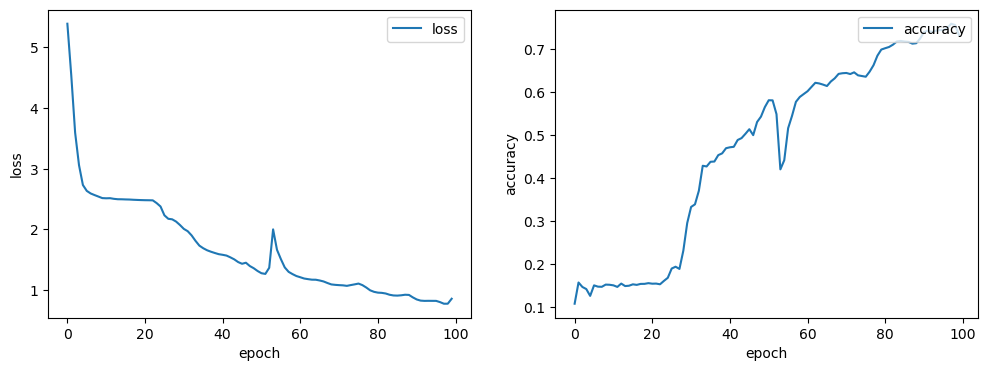

In [114]:
history = memory_model1.fit(train_ds, epochs=100, verbose=0, callbacks=[TqdmCallback()])
utils.plot_history(history, plot_attrs=('loss', 'accuracy'), val=False, figsize=(12,4));

7/7 [==============================] - 4s 75ms/step


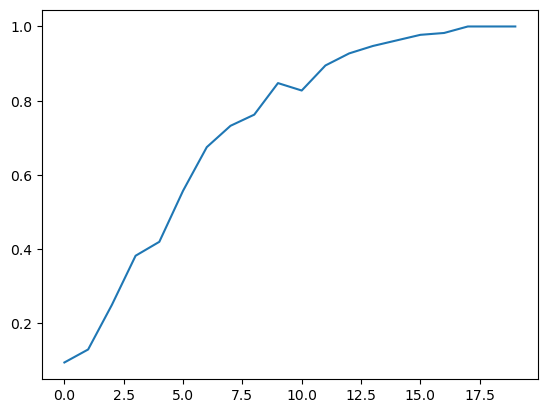

In [115]:
memory_model1.evaluate(train_ds)
memory_model1.evaluate(test_ds)

# plot accuracy as a function of position in sequence
preds = memory_model1.predict(train_ds)
preds = np.argmax(preds, axis=-1)
acc_by_pos = np.mean(preds == seqs_y_train, axis=0)
plt.plot(acc_by_pos)

## Kernel Model2,  Normalization added to Seq2seq transformer
##### CrossAttn Value = embedded_mem_y_seq, softmax added in the end and from_logits = False, n_heads = 4, batch_size = 64, initialize batch = 64

In [117]:
from transformer_modules import AddPositionalEmbedding
import numpy as np
class MemoryModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, n_heads, **kwargs):
        super().__init__(**kwargs)

        self.alpha_it = None
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.pos_embedder_adder  = AddPositionalEmbedding(name='pos_embedder_adder')
        self.memory_pos_embedder_adder = MemoryAddPositionalEmbedding(name='mem_pos_embedder_adder')

        # different attention layers for input and memories
        self.self_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=embedding_dim//n_heads, value_dim=embedding_dim//n_heads, name='self_attn')
        self.memory_self_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=embedding_dim//n_heads, value_dim=embedding_dim//n_heads, name='mem_self_attn')
        
        # FF layer
        self.output_dense = layers.Dense(vocab_size, name='output')
       
        # create cross attention layer
        self.cross_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=key_dim, value_dim=embedding_dim//n_heads, name='cross_attn')
        
        # normalization
        self.layernorm = layers.LayerNormalization()

    def self_attention(self, seq):
        return self.self_attention_layer(seq, seq, use_causal_mask=True)

    def memory_self_attention(self, mem_seqs):
        lambda_fn = lambda x: self.memory_self_attention_layer(x, x, use_causal_mask=False)
        return tf.map_fn(lambda_fn, mem_seqs)

    def call(self, inputs):
        seq_input, memory_x_input, memory_y_input = inputs

        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_x_input)
        embedded_mem_y_seqs = self.embedder(memory_y_input)

        embedded_input_seqs = self.pos_embedder_adder(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_pos_embedder_adder(embedded_mem_x_seqs)
        embedded_mem_y_seqs = self.memory_pos_embedder_adder(embedded_mem_y_seqs)
       
        embedded_input_seqs = self.self_attention(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_self_attention(embedded_mem_x_seqs)
        # embedded_input_seqs.shape (batch_size, input_length, embedding_dim)
        # embedded_mem_x_seqs.shape (batch_size, num_memories, memory_length, embedding_dim)

        w_it_list = []
        logit_list = []
        # compute cross_attention_output here
        for t in range(embedded_mem_x_seqs.shape[1]):
            cross_attention_output = self.cross_attention_layer(
                query=embedded_input_seqs, 
                value=embedded_mem_y_seqs[:,t,:,:], 
                key=embedded_mem_x_seqs[:,t,:,:])
            # cross_attention_output.shape (batch_size, input_seq_length, embedding dim)

            # Compute logits from cross_attention_output
            # Layer normalization
            logits = self.layernorm(self.output_dense(cross_attention_output))
            
            logit_list.append(logits)
            sums = []
            for i in range(input_seq_len):
                sum_up_to_i = tf.reduce_sum(logits[:, :i, :], axis=1)
                sums.append(sum_up_to_i)
            # calc w_it for each t
            # to stack the results along the second dimension again
            w_it = tf.stack(sums, axis=1)  
            w_it_list.append(w_it)
        w_it_list = tf.stack(w_it_list, axis = 1)
        # w_it_list.shape （batch_size, num_memory, input_seq_length, vocab_size)

        logits_list = tf.stack(logit_list, axis = 1)
        # logits_list.shape （batch_size, num_memory, input_seq_length, vocab_size)
        
        alpha_it = tf.nn.softmax(w_it_list, axis=1)
        # alpha_it_list.shape （batch_size, num_memory, input_seq_length, vocab_size)
        
        self.alpha_it = alpha_it
        
        # Elementwise multiplication
        multiplied_tensor = alpha_it * tf.math.exp(logits_list)
    
        # Sum over t
        result = tf.reduce_sum(multiplied_tensor, axis=1)
        result = tf.nn.softmax(result, axis=2)
        # result.shape （batch_size, input_seq_length, vocab_size)
       
        return result

In [118]:
vocab_size = len(state_tuples)
embedding_dim = 64
memory_model2 = MemoryModel(
    vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim//4, n_heads=4, name='memory_model')

memory_model2([seqs_x_train[:64], mem_seqs_x_train[:64], mem_seqs_y_train[:64]]); # build model
create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
memory_model2.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
memory_model2.summary()

Model: "memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  16384     
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0         
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 self_attn (MultiHeadAttenti  multiple                 16640     
 on)                                                             
                                                                 
 mem_self_attn (MultiHeadAtt  multiple                 16640     
 ention)                                              

100%|██████████| 100/100 [05:07<00:00,  3.07s/epoch, loss=0.619, accuracy=0.812]


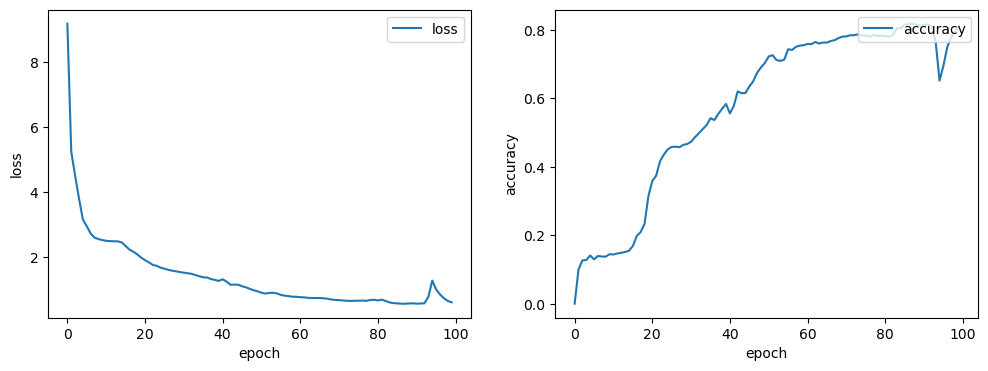

In [119]:
history2 = memory_model2.fit(train_ds, epochs=100, verbose=0, callbacks=[TqdmCallback()])
utils.plot_history(history2, plot_attrs=('loss', 'accuracy'), val=False, figsize=(12,4));

7/7 [==============================] - 1s 98ms/step


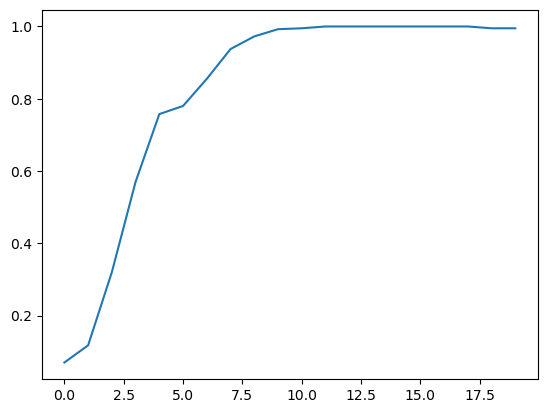

In [126]:
memory_model2.evaluate(train_ds)
memory_model2.evaluate(test_ds)

# plot accuracy as a function of position in sequence
preds2 = memory_model2.predict(train_ds)
preds2 = np.argmax(preds2, axis=-1)
acc_by_pos2 = np.mean(preds2 == seqs_y_train, axis=0)
plt.plot(acc_by_pos2)

## Kernel Model3, No Normalization, no softmax in the end of memorymodel, from_logits = True
##### CrossAttn Value = embedded_mem_y_seq, no softmax in the end of memorymodel, from_logits = True, n_heads = 4, batch_size = 64, initialize batch = 64

In [143]:
from transformer_modules import AddPositionalEmbedding
import numpy as np
class MemoryModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, n_heads, **kwargs):
        super().__init__(**kwargs)

        self.alpha_it = None
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.pos_embedder_adder  = AddPositionalEmbedding(name='pos_embedder_adder')
        self.memory_pos_embedder_adder = MemoryAddPositionalEmbedding(name='mem_pos_embedder_adder')

        # different attention layers for input and memories
        self.self_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=embedding_dim//n_heads, value_dim=embedding_dim//n_heads, name='self_attn')
        self.memory_self_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=embedding_dim//n_heads, value_dim=embedding_dim//n_heads, name='mem_self_attn')
        
        # FF layer
        self.output_dense = layers.Dense(vocab_size, name='output')
       
        # create cross attention layer
        self.cross_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=key_dim, value_dim=embedding_dim//n_heads, name='cross_attn')
        
        # normalization
        self.layernorm = layers.LayerNormalization()

    def self_attention(self, seq):
        return self.self_attention_layer(seq, seq, use_causal_mask=True)

    def memory_self_attention(self, mem_seqs):
        lambda_fn = lambda x: self.memory_self_attention_layer(x, x, use_causal_mask=False)
        return tf.map_fn(lambda_fn, mem_seqs)

    def call(self, inputs):
        seq_input, memory_x_input, memory_y_input = inputs

        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_x_input)
        embedded_mem_y_seqs = self.embedder(memory_y_input)

        embedded_input_seqs = self.pos_embedder_adder(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_pos_embedder_adder(embedded_mem_x_seqs)
        embedded_mem_y_seqs = self.memory_pos_embedder_adder(embedded_mem_y_seqs)
       
        embedded_input_seqs = self.self_attention(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_self_attention(embedded_mem_x_seqs)
        # embedded_input_seqs.shape (batch_size, input_length, embedding_dim)
        # embedded_mem_x_seqs.shape (batch_size, num_memories, memory_length, embedding_dim)

        w_it_list = []
        logit_list = []
        # compute cross_attention_output here
        for t in range(embedded_mem_x_seqs.shape[1]):
            cross_attention_output = self.cross_attention_layer(
                query=embedded_input_seqs, 
                value=embedded_mem_y_seqs[:,t,:,:], 
                key=embedded_mem_x_seqs[:,t,:,:])
            # cross_attention_output.shape (batch_size, input_seq_length, embedding dim)

            # Compute logits from cross_attention_output
            # No Layer normalization here
            logits = self.output_dense(cross_attention_output)
            
            logit_list.append(logits)
            sums = []
            for i in range(input_seq_len):
                sum_up_to_i = tf.reduce_sum(logits[:, :i, :], axis=1)
                sums.append(sum_up_to_i)
            # calc w_it for each t
            # to stack the results along the second dimension again
            w_it = tf.stack(sums, axis=1)  
            w_it_list.append(w_it)
        w_it_list = tf.stack(w_it_list, axis = 1)
        # w_it_list.shape （batch_size, num_memory, input_seq_length, vocab_size)

        logits_list = tf.stack(logit_list, axis = 1)
        # logits_list.shape （batch_size, num_memory, input_seq_length, vocab_size)
        
        alpha_it = tf.nn.softmax(w_it_list, axis=1)
        # alpha_it_list.shape （batch_size, num_memory, input_seq_length, vocab_size)
        
        self.alpha_it = alpha_it
        
        # Elementwise multiplication
        multiplied_tensor = alpha_it * tf.math.exp(logits_list)
    
        # Sum over t
        result = tf.reduce_sum(multiplied_tensor, axis=1)
        # result.shape （batch_size, input_seq_length, vocab_size)
       
        return result

In [146]:
vocab_size = len(state_tuples)
embedding_dim = 64
memory_model3 = MemoryModel(
    vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim//4, n_heads=4, name='memory_model')

memory_model3([seqs_x_train[:64], mem_seqs_x_train[:64], mem_seqs_y_train[:64]]); # build model
create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
memory_model3.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
memory_model3.summary()

Model: "memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  16384     
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0         
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 self_attn (MultiHeadAttenti  multiple                 16640     
 on)                                                             
                                                                 
 mem_self_attn (MultiHeadAtt  multiple                 16640     
 ention)                                              

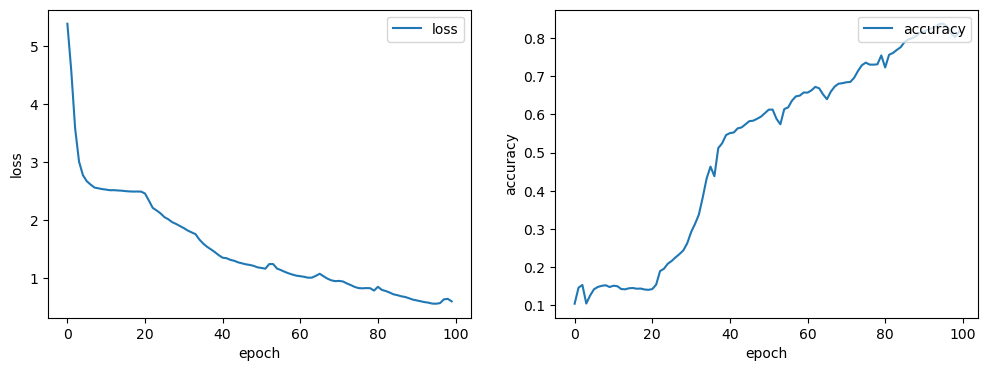

In [147]:
history3 = memory_model3.fit(train_ds, epochs=100, verbose=0, callbacks=[TqdmCallback()])
utils.plot_history(history3, plot_attrs=('loss', 'accuracy'), val=False, figsize=(12,4));

1/7 [===>..........................] - ETA: 0s - loss: 0.6427 - accuracy: 0.8078

7/7 [==============================] - 1s 76ms/step


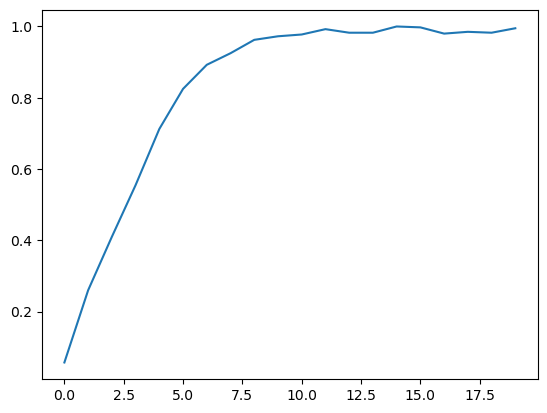

In [149]:
memory_model3.evaluate(train_ds)
memory_model3.evaluate(test_ds)

# plot accuracy as a function of position in sequence
preds3 = memory_model3.predict(train_ds)
preds3 = np.argmax(preds3, axis=-1)
acc_by_pos3 = np.mean(preds3 == seqs_y_train, axis=0)
plt.plot(acc_by_pos3)

## Kernel Model4, Normalization added to seq2seq transformer & the end
##### CrossAttn Value = embedded_mem_y_seq, from_logits = False, n_heads = 4, batch_size = 64, initialize batch = 64

In [123]:
from transformer_modules import AddPositionalEmbedding
import numpy as np
class MemoryModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, n_heads, **kwargs):
        super().__init__(**kwargs)

        self.alpha_it = None
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.pos_embedder_adder  = AddPositionalEmbedding(name='pos_embedder_adder')
        self.memory_pos_embedder_adder = MemoryAddPositionalEmbedding(name='mem_pos_embedder_adder')

        # different attention layers for input and memories
        self.self_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=embedding_dim//n_heads, value_dim=embedding_dim//n_heads, name='self_attn')
        self.memory_self_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=embedding_dim//n_heads, value_dim=embedding_dim//n_heads, name='mem_self_attn')
        
        # FF layer
        self.output_dense = layers.Dense(vocab_size, name='output')
       
        # create cross attention layer
        self.cross_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=key_dim, value_dim=embedding_dim//n_heads, name='cross_attn')
        
        # normalization
        self.layernorm = layers.LayerNormalization()

    def self_attention(self, seq):
        return self.self_attention_layer(seq, seq, use_causal_mask=True)

    def memory_self_attention(self, mem_seqs):
        lambda_fn = lambda x: self.memory_self_attention_layer(x, x, use_causal_mask=False)
        return tf.map_fn(lambda_fn, mem_seqs)

    def call(self, inputs):
        seq_input, memory_x_input, memory_y_input = inputs

        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_x_input)
        embedded_mem_y_seqs = self.embedder(memory_y_input)

        embedded_input_seqs = self.pos_embedder_adder(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_pos_embedder_adder(embedded_mem_x_seqs)
        embedded_mem_y_seqs = self.memory_pos_embedder_adder(embedded_mem_y_seqs)
       
        embedded_input_seqs = self.self_attention(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_self_attention(embedded_mem_x_seqs)
        # embedded_input_seqs.shape (batch_size, input_length, embedding_dim)
        # embedded_mem_x_seqs.shape (batch_size, num_memories, memory_length, embedding_dim)

        w_it_list = []
        logit_list = []
        # compute cross_attention_output here
        for t in range(embedded_mem_x_seqs.shape[1]):
            cross_attention_output = self.cross_attention_layer(
                query=embedded_input_seqs, 
                value=embedded_mem_y_seqs[:,t,:,:], 
                key=embedded_mem_x_seqs[:,t,:,:])
            # cross_attention_output.shape (batch_size, input_seq_length, embedding dim)

            # Compute logits from cross_attention_output
            # First Layer normalization here
            logits = self.layernorm(self.output_dense(cross_attention_output))
            
            logit_list.append(logits)
            sums = []
            for i in range(input_seq_len):
                sum_up_to_i = tf.reduce_sum(logits[:, :i, :], axis=1)
                sums.append(sum_up_to_i)
            # calc w_it for each t
            # to stack the results along the second dimension again
            w_it = tf.stack(sums, axis=1)  
            w_it_list.append(w_it)
        w_it_list = tf.stack(w_it_list, axis = 1)
        # w_it_list.shape （batch_size, num_memory, input_seq_length, vocab_size)

        logits_list = tf.stack(logit_list, axis = 1)
        # logits_list.shape （batch_size, num_memory, input_seq_length, vocab_size)
        
        alpha_it = tf.nn.softmax(w_it_list, axis=1)
        # alpha_it_list.shape （batch_size, num_memory, input_seq_length, vocab_size)
        
        self.alpha_it = alpha_it
        
        # Elementwise multiplication
        multiplied_tensor = alpha_it * tf.math.exp(logits_list)
    
        # Sum over t
        result = tf.reduce_sum(multiplied_tensor, axis=1)
        # Layer normalization here 
        result = self.layernorm(result)
        result = tf.nn.softmax(result, axis=2)
        # result.shape （batch_size, input_seq_length, vocab_size)
       
        return result

In [124]:
vocab_size = len(state_tuples)
embedding_dim = 64
memory_model4 = MemoryModel(
    vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim//4, n_heads=4, name='memory_model')

memory_model4([seqs_x_train[:64], mem_seqs_x_train[:64], mem_seqs_y_train[:64]]); # build model
create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
memory_model4.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
memory_model4.summary()

Model: "memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  16384     
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0         
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 self_attn (MultiHeadAttenti  multiple                 16640     
 on)                                                             
                                                                 
 mem_self_attn (MultiHeadAtt  multiple                 16640     
 ention)                                              

100%|██████████| 100/100 [04:37<00:00,  2.78s/epoch, loss=0.668, accuracy=0.806]


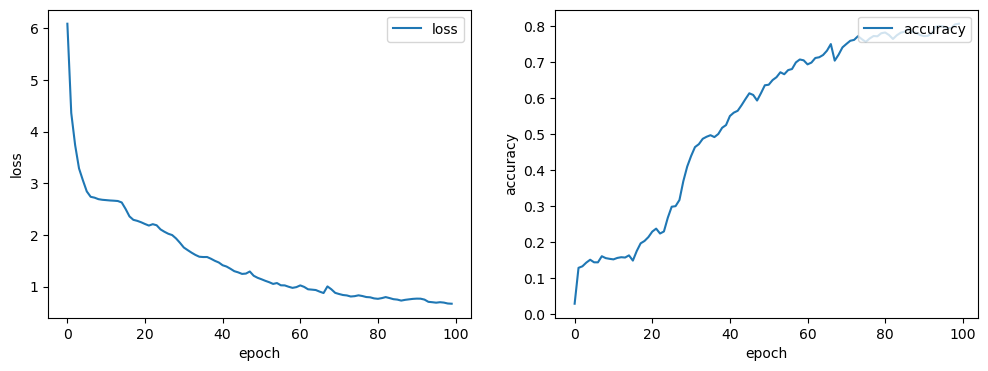

In [125]:
history4 = memory_model4.fit(train_ds, epochs=100, verbose=0, callbacks=[TqdmCallback()])
utils.plot_history(history4, plot_attrs=('loss', 'accuracy'), val=False, figsize=(12,4));

7/7 [==============================] - 5s 104ms/step


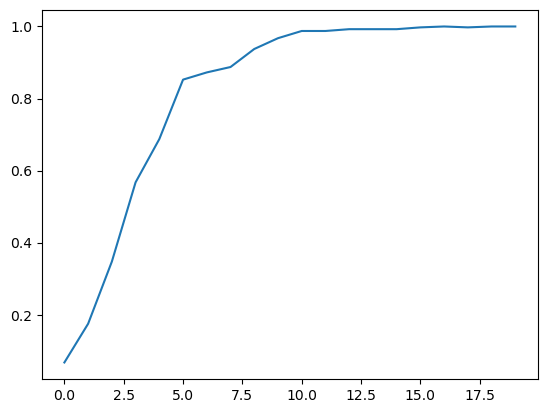

In [127]:
memory_model4.evaluate(train_ds)
memory_model4.evaluate(test_ds)

# plot accuracy as a function of position in sequence
preds4 = memory_model4.predict(train_ds)
preds4 = np.argmax(preds4, axis=-1)
acc_by_pos4 = np.mean(preds4 == seqs_y_train, axis=0)
plt.plot(acc_by_pos4)

## Kernel Model 5: no softmax added, layer_normalization added, from_logits = True


In [129]:
# no softmax and use_logit = True

from transformer_modules import AddPositionalEmbedding
import numpy as np
class MemoryModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, n_heads, **kwargs):
        super().__init__(**kwargs)

        self.alpha_it = None
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.pos_embedder_adder  = AddPositionalEmbedding(name='pos_embedder_adder')
        self.memory_pos_embedder_adder = MemoryAddPositionalEmbedding(name='mem_pos_embedder_adder')

        # different attention layers for input and memories
        self.self_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=embedding_dim//n_heads, value_dim=embedding_dim//n_heads, name='self_attn')
        self.memory_self_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=embedding_dim//n_heads, value_dim=embedding_dim//n_heads, name='mem_self_attn')
        
        # FF layer
        self.output_dense = layers.Dense(vocab_size, name='output')
       
        # create cross attention layer
        self.cross_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=key_dim, value_dim=embedding_dim//n_heads, name='cross_attn')
        
        # normalization
        self.layernorm = layers.LayerNormalization()

    def self_attention(self, seq):
        return self.self_attention_layer(seq, seq, use_causal_mask=True)

    def memory_self_attention(self, mem_seqs):
        lambda_fn = lambda x: self.memory_self_attention_layer(x, x, use_causal_mask=False)
        return tf.map_fn(lambda_fn, mem_seqs)

    def call(self, inputs):
        seq_input, memory_x_input, memory_y_input = inputs

        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_x_input)
        embedded_mem_y_seqs = self.embedder(memory_y_input)

        embedded_input_seqs = self.pos_embedder_adder(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_pos_embedder_adder(embedded_mem_x_seqs)
        embedded_mem_y_seqs = self.memory_pos_embedder_adder(embedded_mem_y_seqs)
       
        embedded_input_seqs = self.self_attention(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_self_attention(embedded_mem_x_seqs)
        # embedded_input_seqs.shape (batch_size, input_length, embedding_dim)
        # embedded_mem_x_seqs.shape (batch_size, num_memories, memory_length, embedding_dim)

        w_it_list = []
        logit_list = []
        # compute cross_attention_output here
        for t in range(embedded_mem_x_seqs.shape[1]):
            cross_attention_output = self.cross_attention_layer(
                query=embedded_input_seqs, 
                value=embedded_mem_y_seqs[:,t,:,:], 
                key=embedded_mem_x_seqs[:,t,:,:])
            # cross_attention_output.shape (batch_size, input_seq_length, embedding dim)

            # Compute logits from cross_attention_output
            # First Layer normalization here
            logits = self.layernorm(self.output_dense(cross_attention_output))
            
            logit_list.append(logits)
            sums = []
            for i in range(input_seq_len):
                sum_up_to_i = tf.reduce_sum(logits[:, :i, :], axis=1)
                sums.append(sum_up_to_i)
            # calc w_it for each t
            # to stack the results along the second dimension again
            w_it = tf.stack(sums, axis=1)  
            w_it_list.append(w_it)
        w_it_list = tf.stack(w_it_list, axis = 1)
        # w_it_list.shape （batch_size, num_memory, input_seq_length, vocab_size)

        logits_list = tf.stack(logit_list, axis = 1)
        # logits_list.shape （batch_size, num_memory, input_seq_length, vocab_size)
        
        alpha_it = tf.nn.softmax(w_it_list, axis=1)
        # alpha_it_list.shape （batch_size, num_memory, input_seq_length, vocab_size)
        
        self.alpha_it = alpha_it
        
        # Elementwise multiplication
        multiplied_tensor = alpha_it * tf.math.exp(logits_list)
    
        # Sum over t
        result = tf.reduce_sum(multiplied_tensor, axis=1)
        # Layer normalization here 
        
        # result.shape （batch_size, input_seq_length, vocab_size)
       
        return result

In [130]:
vocab_size = len(state_tuples)
embedding_dim = 64
memory_model5 = MemoryModel(
    vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim//4, n_heads=4, name='memory_model')

memory_model5([seqs_x_train[:64], mem_seqs_x_train[:64], mem_seqs_y_train[:64]]); # build model
create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
memory_model5.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
memory_model5.summary()

Model: "memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  16384     
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0         
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 self_attn (MultiHeadAttenti  multiple                 16640     
 on)                                                             
                                                                 
 mem_self_attn (MultiHeadAtt  multiple                 16640     
 ention)                                              

100%|██████████| 100/100 [04:56<00:00,  2.97s/epoch, loss=0.581, accuracy=0.817]


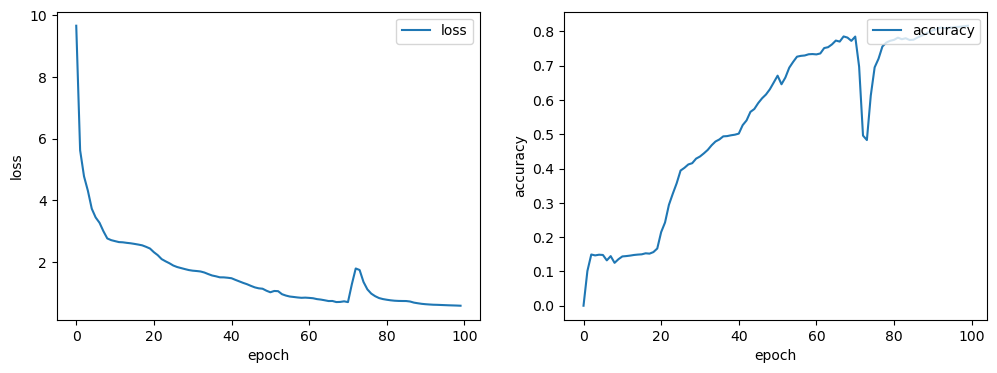

In [131]:
history5 = memory_model5.fit(train_ds, epochs=100, verbose=0, callbacks=[TqdmCallback()])
utils.plot_history(history5, plot_attrs=('loss', 'accuracy'), val=False, figsize=(12,4));

7/7 [==============================] - 5s 112ms/step


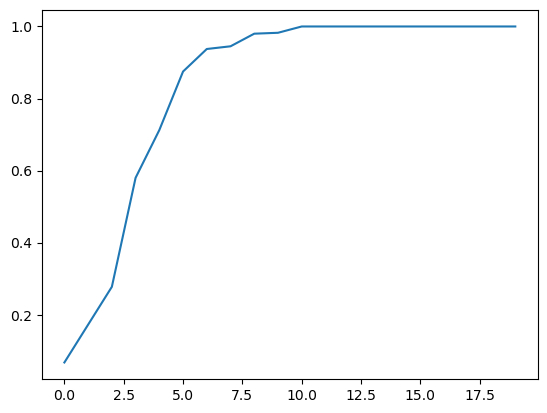

In [132]:
memory_model5.evaluate(train_ds)
memory_model5.evaluate(test_ds)

# plot accuracy as a function of position in sequence
preds5 = memory_model5.predict(train_ds)
preds5 = np.argmax(preds5, axis=-1)
acc_by_pos5 = np.mean(preds5 == seqs_y_train, axis=0)
plt.plot(acc_by_pos5)

## Utility functions and attention visualization

In [196]:

def plot_seq_attention(attn_, mem_seqs_x, train_seqs_x):
    num_mem_seqs = attn_.shape[0]
    fig, ax = plt.subplots(figsize=(num_mem_seqs*4,8))
    im = ax.imshow(attn_, cmap='gray', vmin=0, vmax=1)
    ax.set_yticks(range(len(mem_seqs_x)))
    ax.set_xticks(range(len(train_seqs_x)))
    ax.set_yticklabels([tuple(x) for x in mem_seqs_x]);
    ax.set_xticklabels(train_seqs_x);

    ax.set_xlabel('input sequence')
    ax.set_ylabel('memory sequences')
    ax.set_title('attention over sequences')

    fig.colorbar(im, ax=ax)
    

def plot_attention(sample_input_index, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model):
    """
    choose sample input and plot the attention associated to the argmax probability vocab at each input position 
    (memory_seq versus each input element), call plot_seq_attention as subfunction
    """
    b = sample_input_index
    sample_input = seqs_x_train[b:b+1]
    print("sample_input: ",sample_input)
    sample_mem_seq_x = mem_seqs_x_train[b:b+1]
    sample_mem_seq_y = mem_seqs_y_train[b:b+1]

    pred = memory_model([sample_input, sample_mem_seq_x, sample_mem_seq_y])
    pred = np.argmax(pred, axis=-1)
    print(f'prediction: {pred[0]}')
    print(f'y: {seqs_y_train[b]}')
    print(pred[0] == seqs_y_train[b])
    attn_ = memory_model.alpha_it[0]
    #print(memory_model.alpha_it.shape)
    prob_list = []
    for i in range(attn_.shape[1]):
        prob_list.append(attn_[:,i,pred[0][i]])

    attn_output_seq = tf.stack(prob_list, axis = 1)
    #print(attn_output_seq.shape)
    plot_seq_attention(attn_output_seq, sample_mem_seq_x[0], sample_input[0])

sample_input:  [[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]]
prediction: [ 8 12 12  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6]
y: [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[False False False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
sample_input:  [[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]]
prediction: [15  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6]
y: [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
sample_input:  [[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]]
prediction: [13 13  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6]
y: [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
sample_input:  [[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]]
prediction: [15 12  5  6  6  6  6  6  

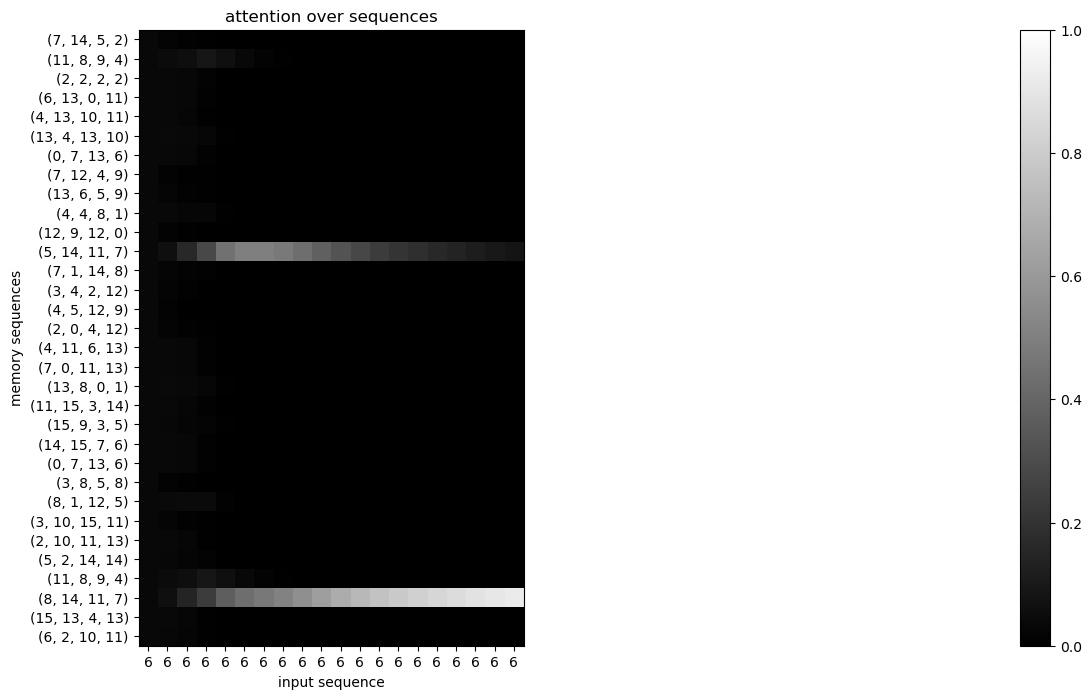

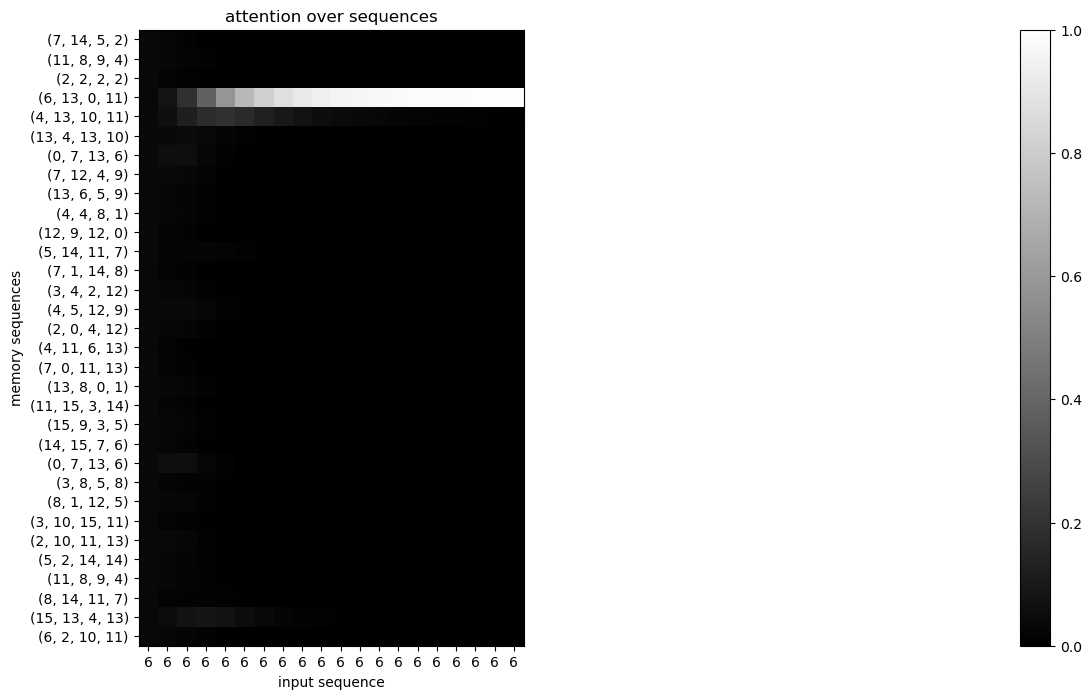

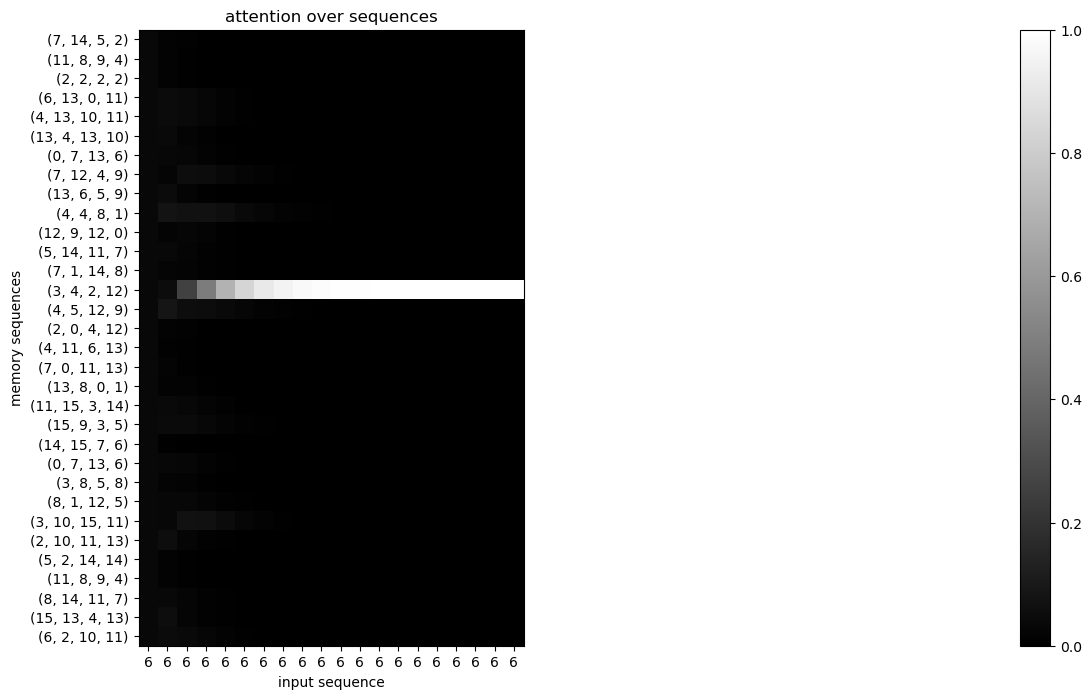

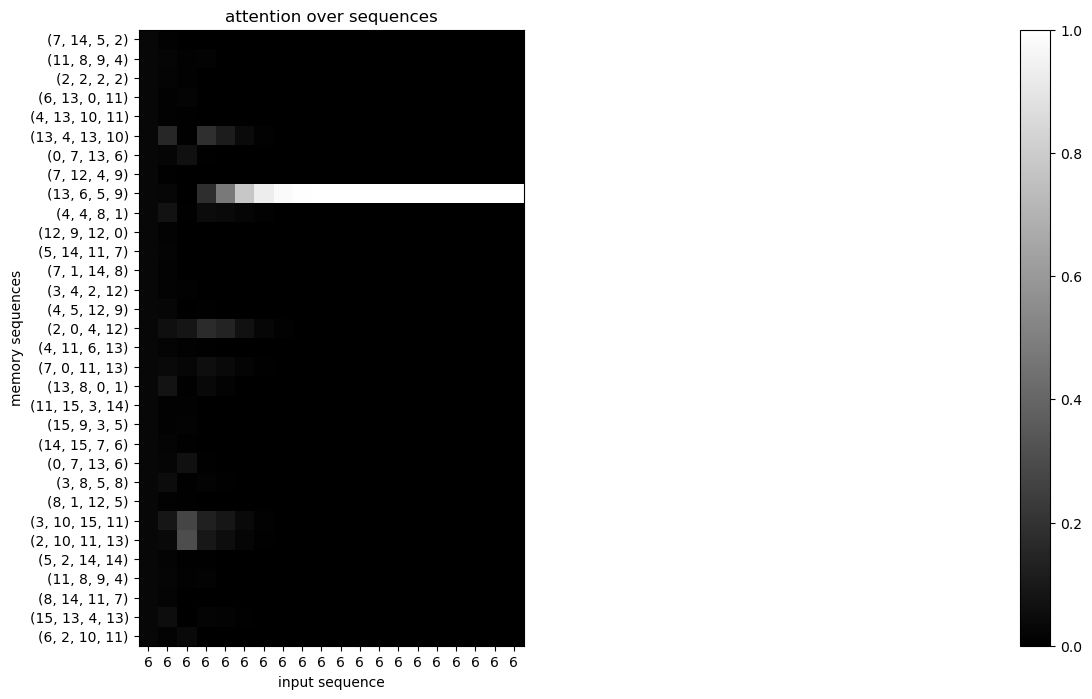

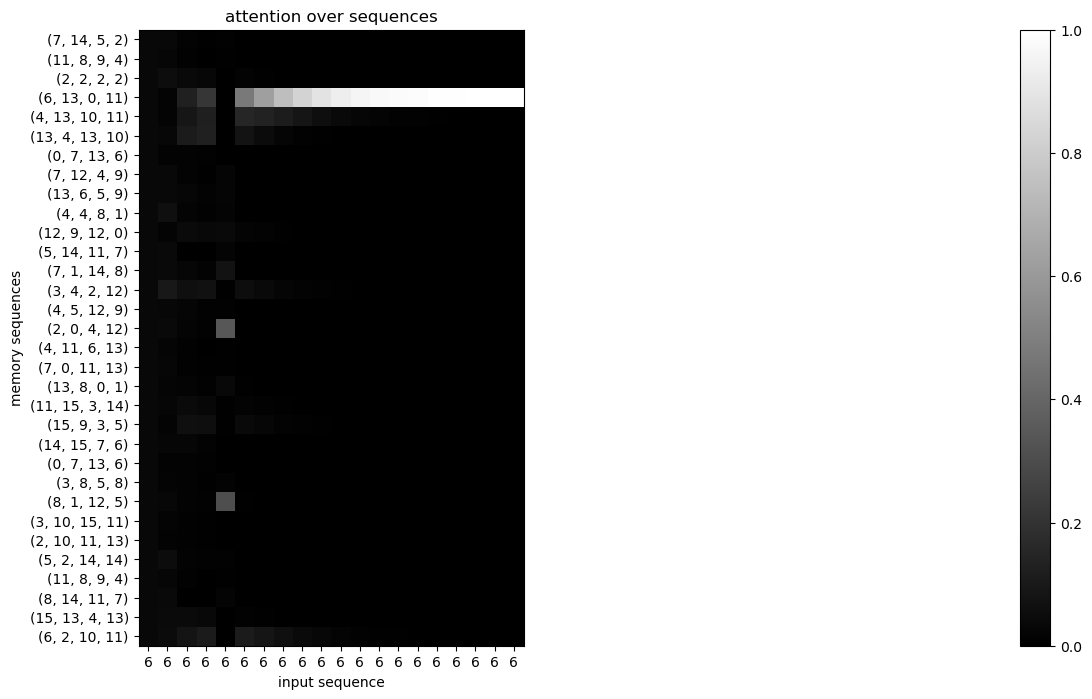

In [197]:
plot_attention(300, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model1)
plot_attention(300, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model2)
plot_attention(300, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model3)
plot_attention(300, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model4)
plot_attention(300, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model5)

sample_input:  [[ 2  9  0 15 12  2  1 15  6 13  0 11 13 10 11 13 10 11 13 10]]
prediction: [ 2 10 13  2  2  2 15  6 13  0 11 13 10 11 13 10 11 13 10 11]
y: [ 9  0 15 12  2  1 15  6 13  0 11 13 10 11 13 10 11 13 10 11]
[False False False False  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
sample_input:  [[ 2  9  0 15 12  2  1 15  6 13  0 11 13 10 11 13 10 11 13 10]]
prediction: [ 1  2  4 12  2  1 15  6 13  0 11 13 10 11 13 10 11 13 10 11]
y: [ 9  0 15 12  2  1 15  6 13  0 11 13 10 11 13 10 11 13 10 11]
[False False False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
sample_input:  [[ 2  9  0 15 12  2  1 15  6 13  0 11 13 10 11 13 10 11 13 10]]
prediction: [ 2 10 15 12  2  1 15  6 13  0 11 13 10 11 13 10 11 13 10 11]
y: [ 9  0 15 12  2  1 15  6 13  0 11 13 10 11 13 10 11 13 10 11]
[False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  T

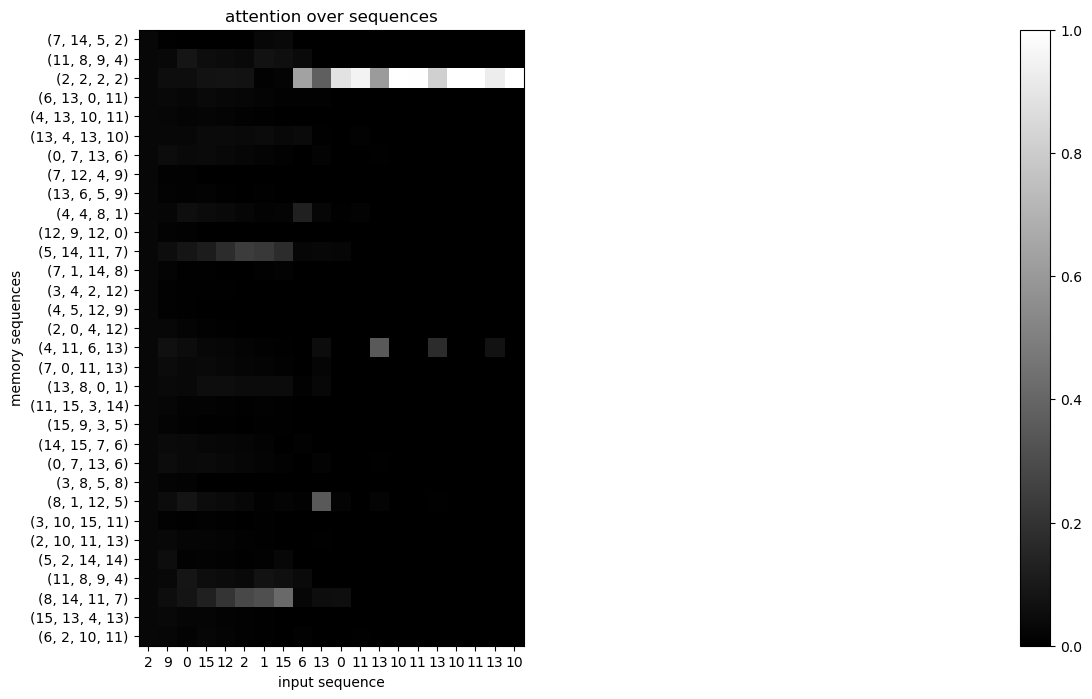

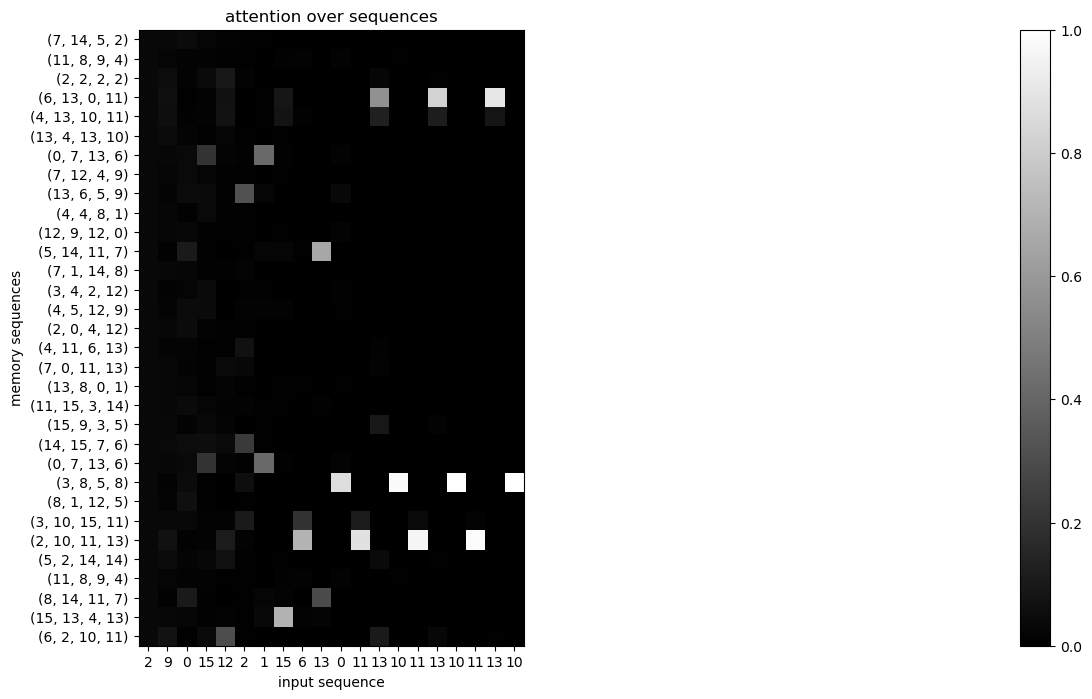

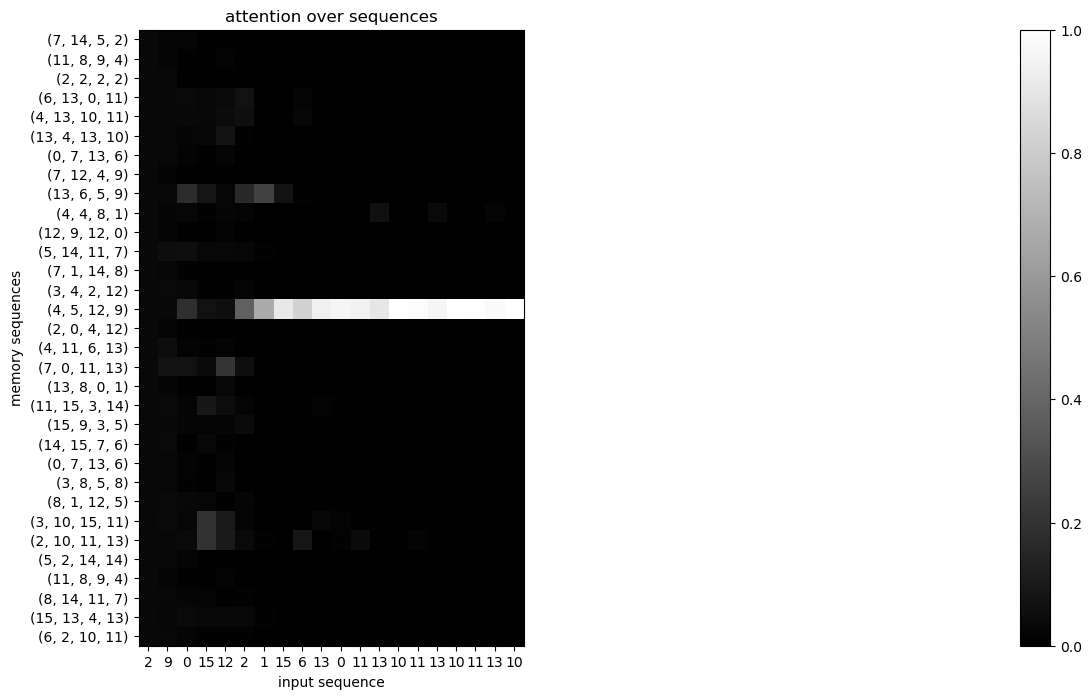

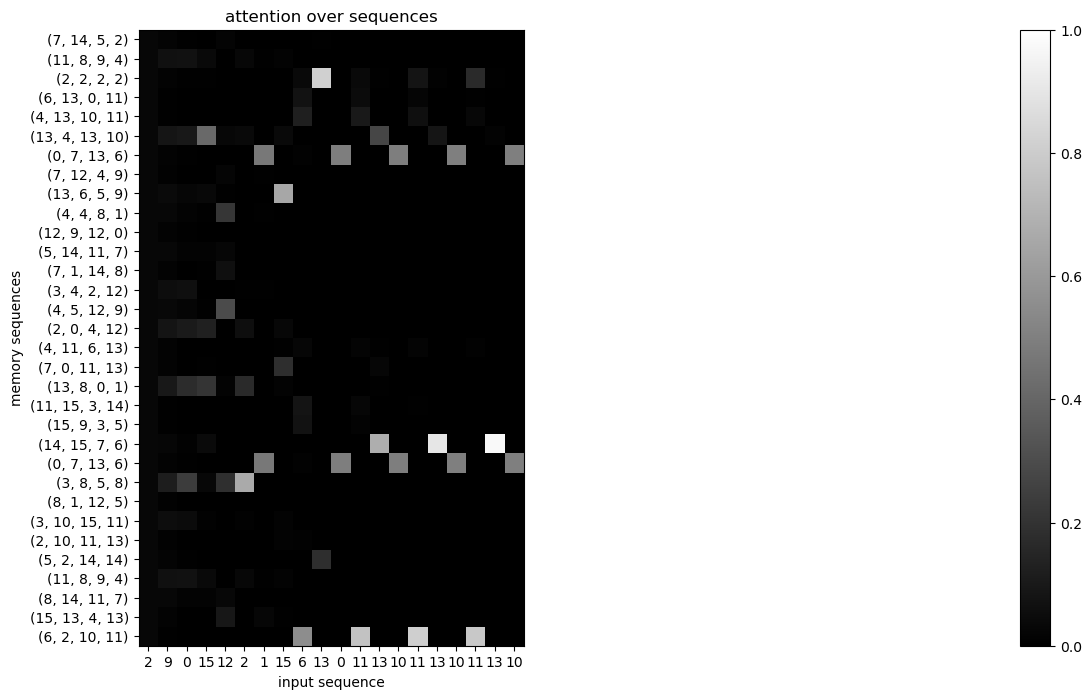

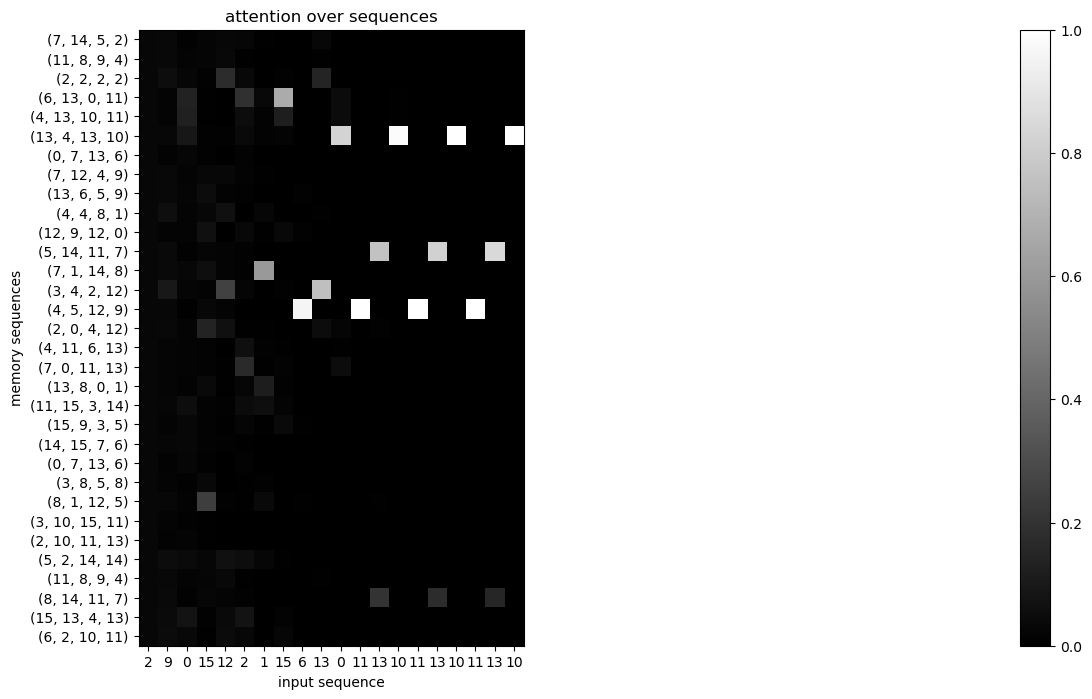

In [153]:
idx = 1
plot_attention(idx, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model1)
plot_attention(idx, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model2)
plot_attention(idx, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model3)
plot_attention(idx, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model4)
plot_attention(idx, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model5)

sample_input:  [[ 6  0 11 13 10 11 13 10 11 13 10 11 13 10 11 13 10 11 13 10]]
prediction: [ 8 13 13 10 11 13 10 11 13 10 11 13 10 11 13 10 11 13 10 11]
y: [ 0 11 13 10 11 13 10 11 13 10 11 13 10 11 13 10 11 13 10 11]
[False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
sample_input:  [[ 6  0 11 13 10 11 13 10 11 13 10 11 13 10 11 13 10 11 13 10]]
prediction: [15  8 13 10 11 13 10 11 13 10 11 13 10 11 13 10 11 13 10 11]
y: [ 0 11 13 10 11 13 10 11 13 10 11 13 10 11 13 10 11 13 10 11]
[False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
sample_input:  [[ 6  0 11 13 10 11 13 10 11 13 10 11 13 10 11 13 10 11 13 10]]
prediction: [13 13 13 10 11 13 10 11 13 10 11 13 10 11 13 10 11 13 10 11]
y: [ 0 11 13 10 11 13 10 11 13 10 11 13 10 11 13 10 11 13 10 11]
[False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  T

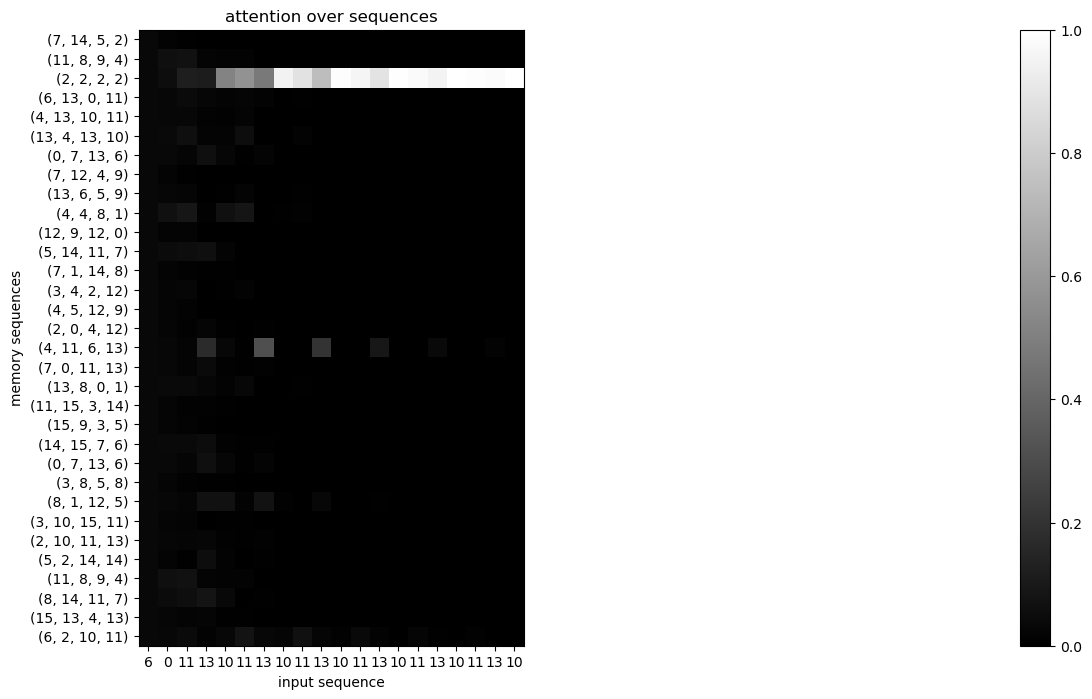

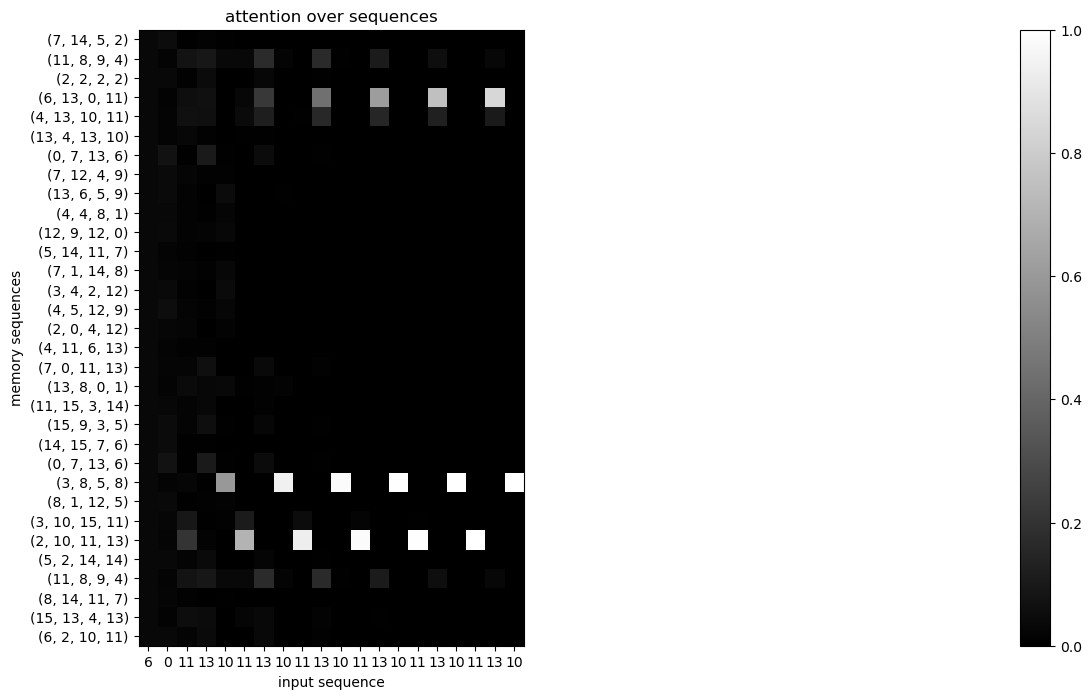

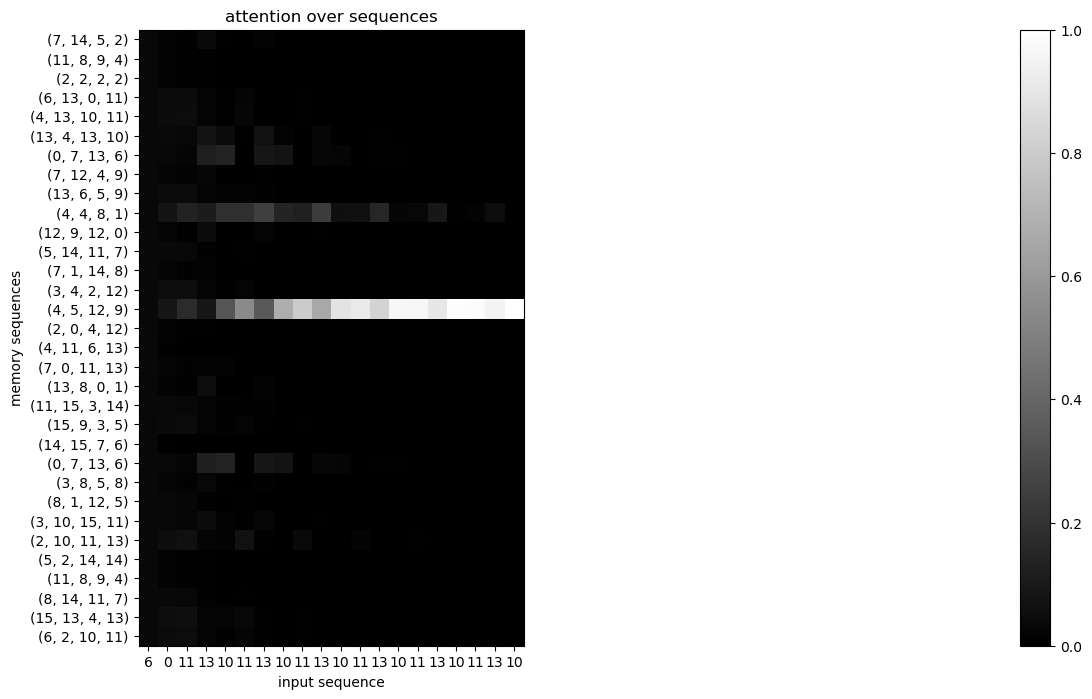

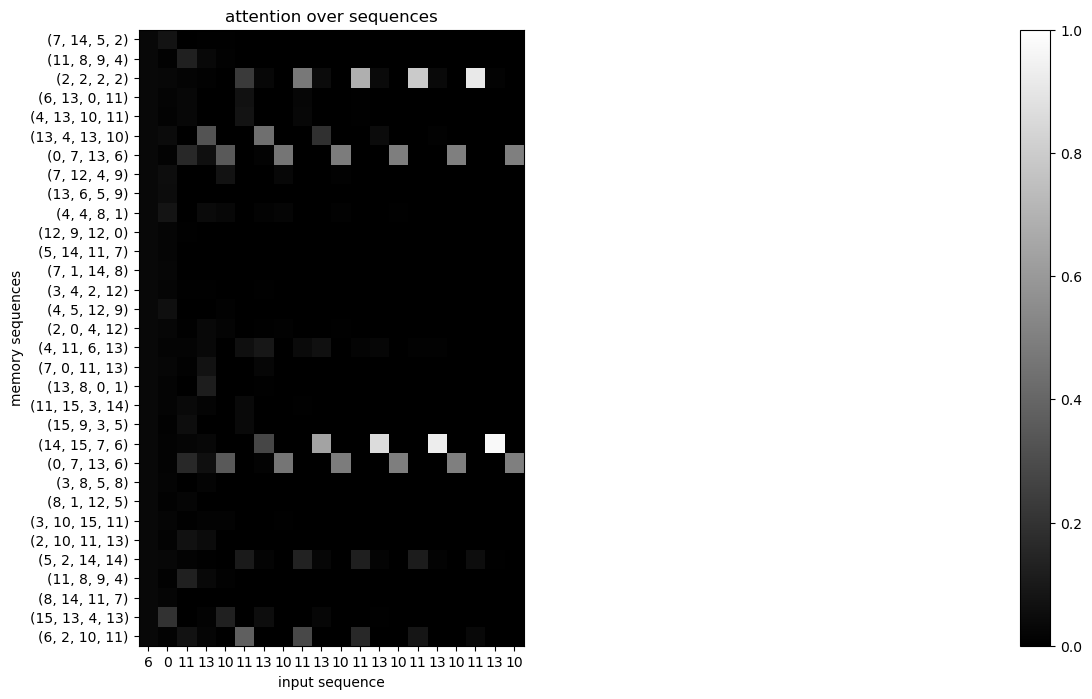

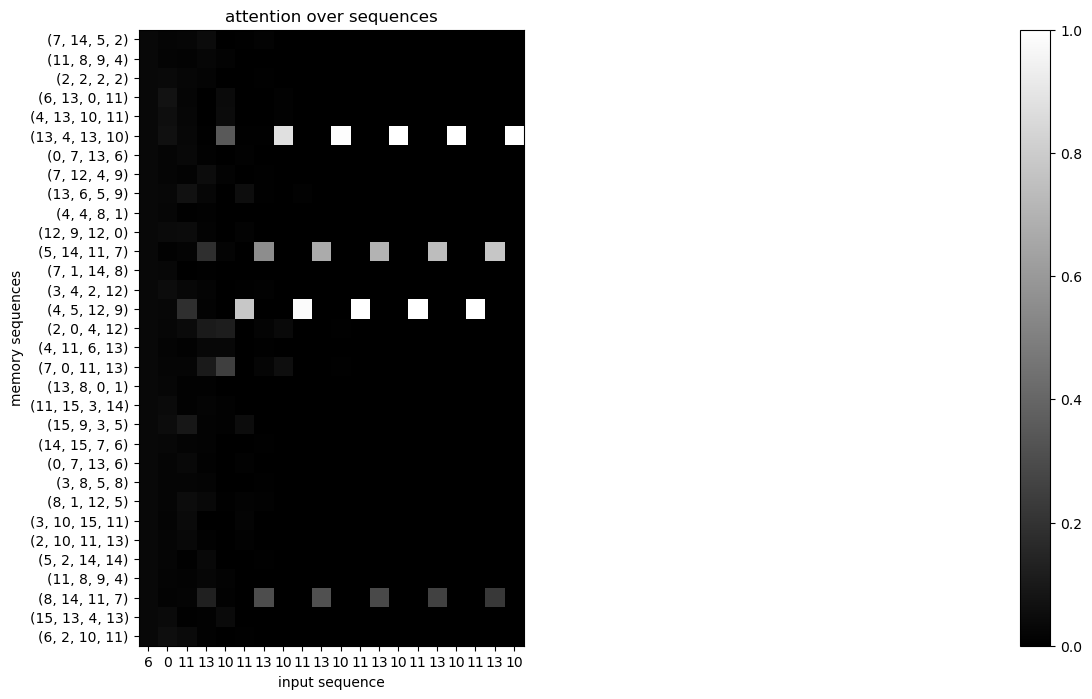

In [180]:
idx = 100
plot_attention(idx, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model1)
plot_attention(idx, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model2)
plot_attention(idx, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model3)
plot_attention(idx, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model4)
plot_attention(idx, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model5)

sample_input:  [[ 9  7  1 14  8  1 12  5 14 11  7  7 12  4  9 14  0 15 12  2]]
prediction: [ 2  2 13  2  2 12  2 14  2  7  7  7  7  4 14  0 15 12  2  1]
y: [ 7  1 14  8  1 12  5 14 11  7  7 12  4  9 14  0 15 12  2  1]
[False False False False False  True False  True False  True  True False
 False False  True  True  True  True  True  True]
sample_input:  [[ 9  7  1 14  8  1 12  5 14 11  7  7 12  4  9 14  0 15 12  2]]
prediction: [ 1  2 15  5 11 12  5 14 11  7  7 12  4  9 14  0 15 12  2  1]
y: [ 7  1 14  8  1 12  5 14 11  7  7 12  4  9 14  0 15 12  2  1]
[False False False False False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
sample_input:  [[ 9  7  1 14  8  1 12  5 14 11  7  7 12  4  9 14  0 15 12  2]]
prediction: [10  2 15 11 15 12  5 14 11  7  2 12  4  9 14  0 15 12  2  1]
y: [ 7  1 14  8  1 12  5 14 11  7  7 12  4  9 14  0 15 12  2  1]
[False False False False False  True  True  True  True  True False  True
  True  True  True  True  T

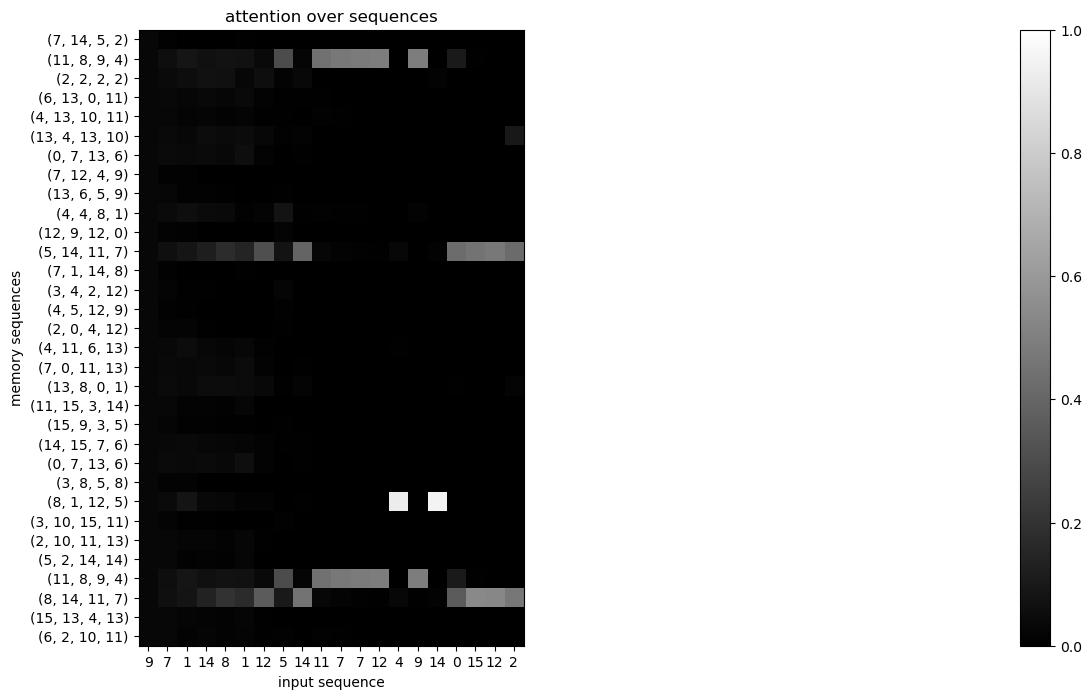

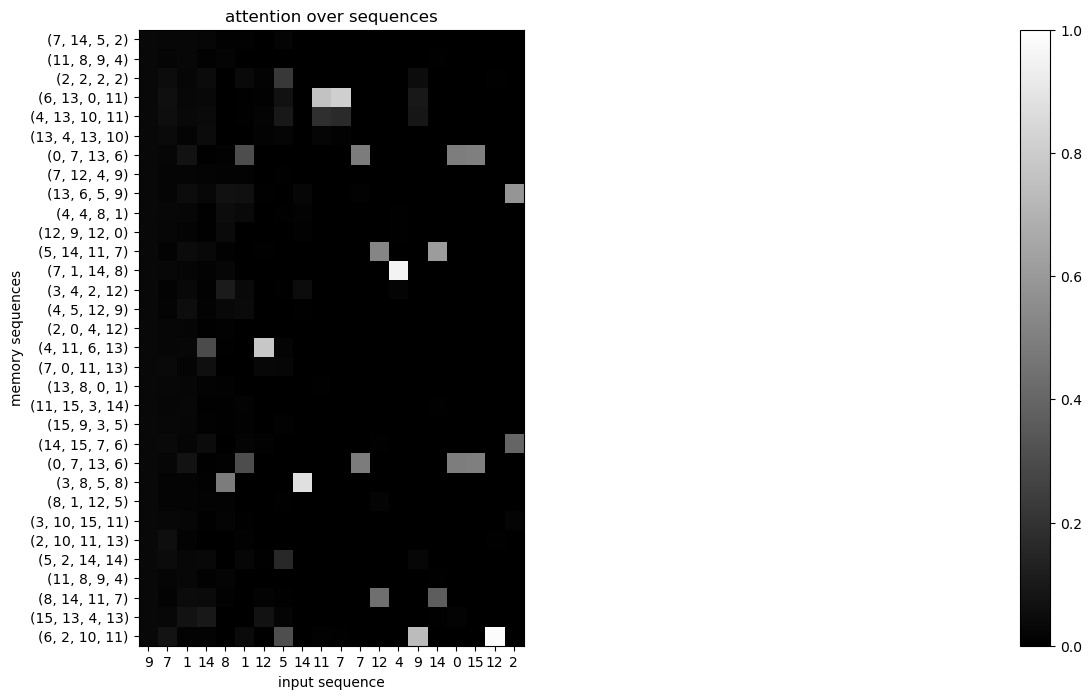

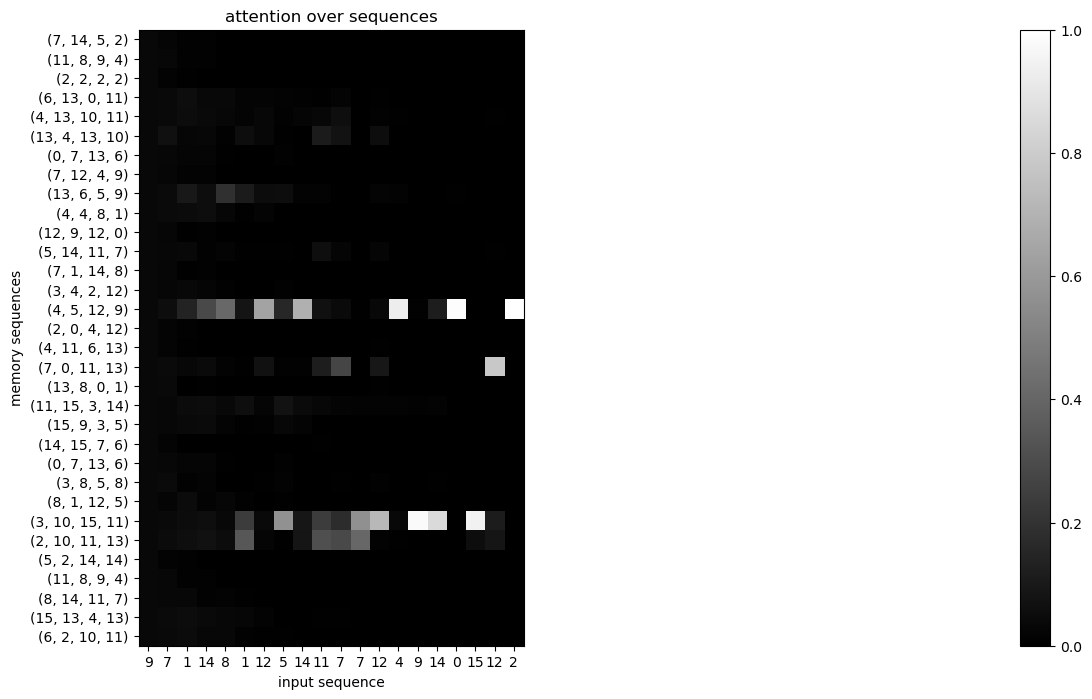

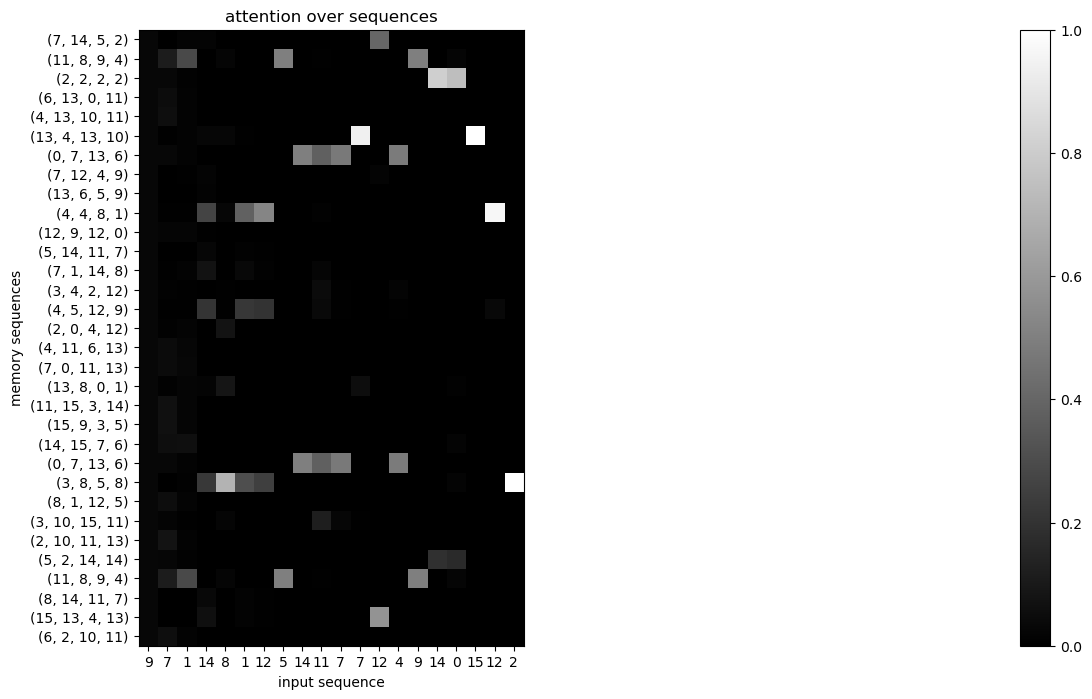

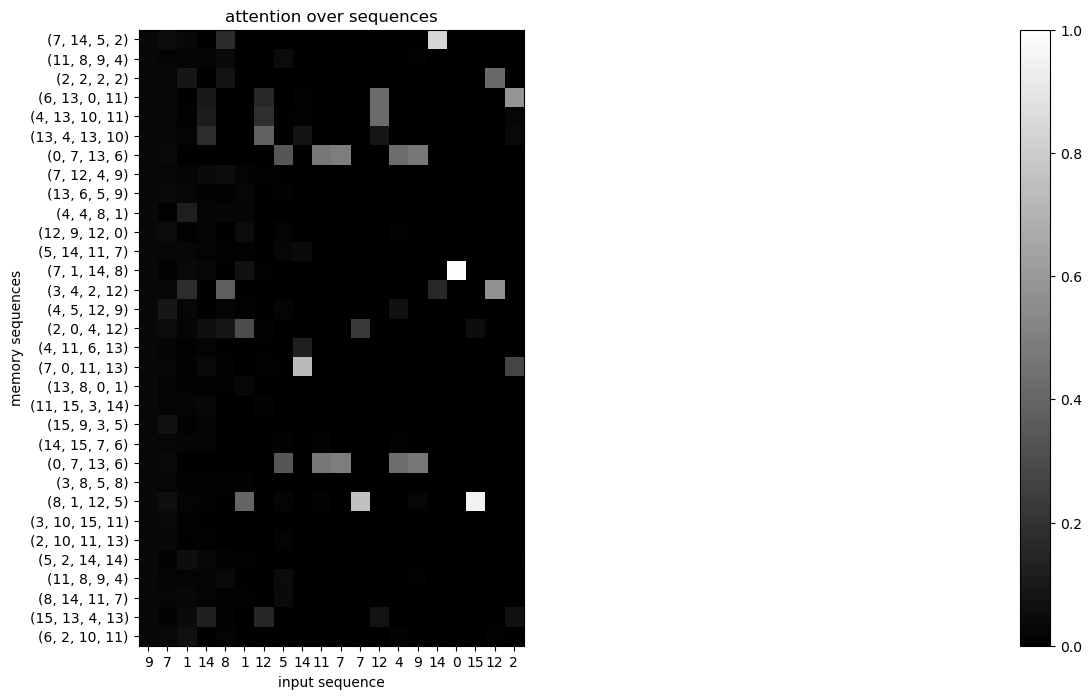

In [181]:
idx = 3

plot_attention(idx, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model1)
plot_attention(idx, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model2)
plot_attention(idx, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model3)
plot_attention(idx, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model4)
plot_attention(idx, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model5)

# memory 8 1 12 5 has high attention in the position later than it shows up in input sequence

sample_input:  [[12  0  8  8 12  2  1 15  6 13  0 11 13 10 11 13 10 11 13 10]]
prediction: [ 2 13  2  2  2  2 15  6 13  0 11 13 10 11 13 10 11 13 10 11]
y: [ 0  8  8 12  2  1 15  6 13  0 11 13 10 11 13 10 11 13 10 11]
[False False False False  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
sample_input:  [[12  0  8  8 12  2  1 15  6 13  0 11 13 10 11 13 10 11 13 10]]
prediction: [ 1 12 12 12 12  0 15 15 13  0 11 13 10 11 13 10 11 13 10 11]
y: [ 0  8  8 12  2  1 15  6 13  0 11 13 10 11 13 10 11 13 10 11]
[False False False  True False False  True False  True  True  True  True
  True  True  True  True  True  True  True  True]
sample_input:  [[12  0  8  8 12  2  1 15  6 13  0 11 13 10 11 13 10 11 13 10]]
prediction: [ 2  9 15 15 11 15 15  6 13  0 11 13 10 11 13 10 11 13 10 11]
y: [ 0  8  8 12  2  1 15  6 13  0 11 13 10 11 13 10 11 13 10 11]
[False False False False False False  True  True  True  True  True  True
  True  True  True  True  T

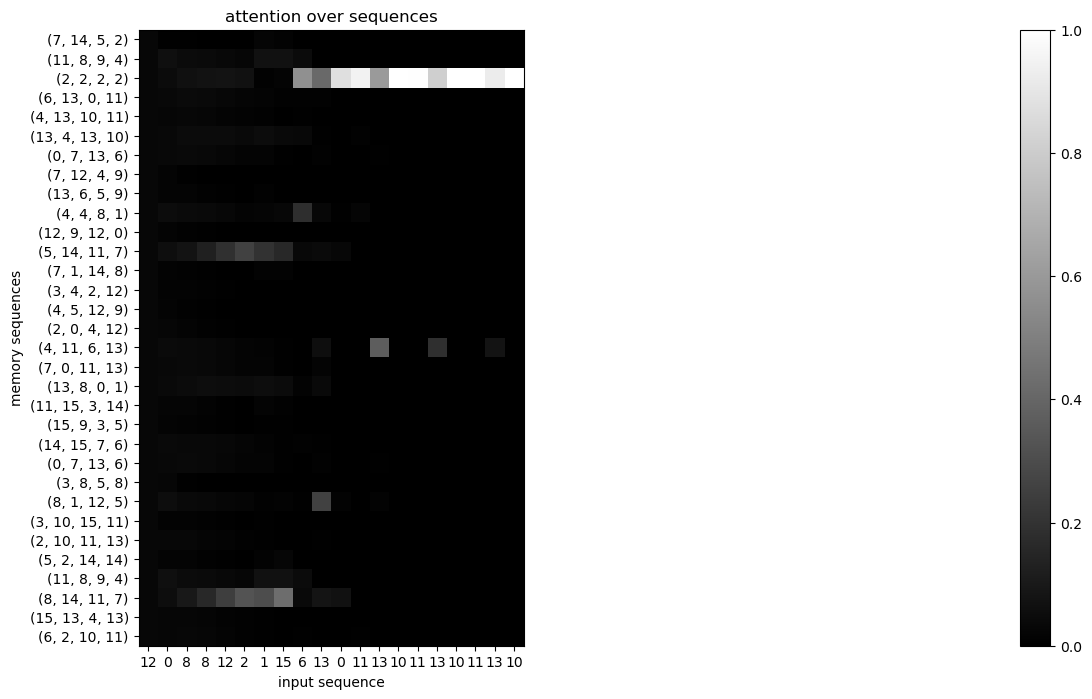

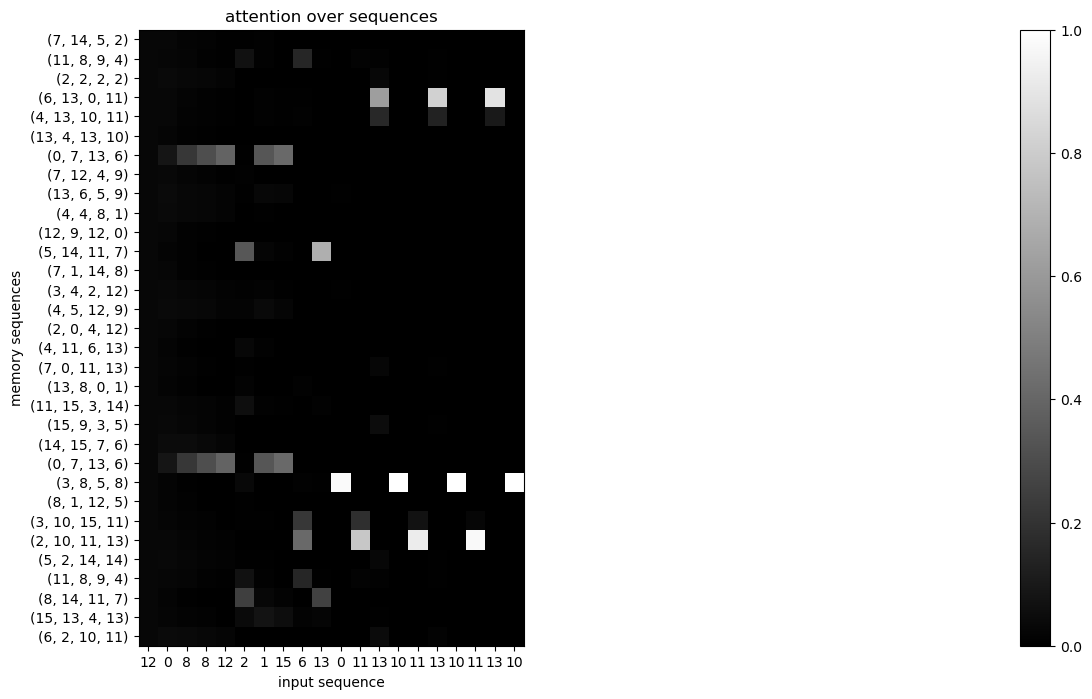

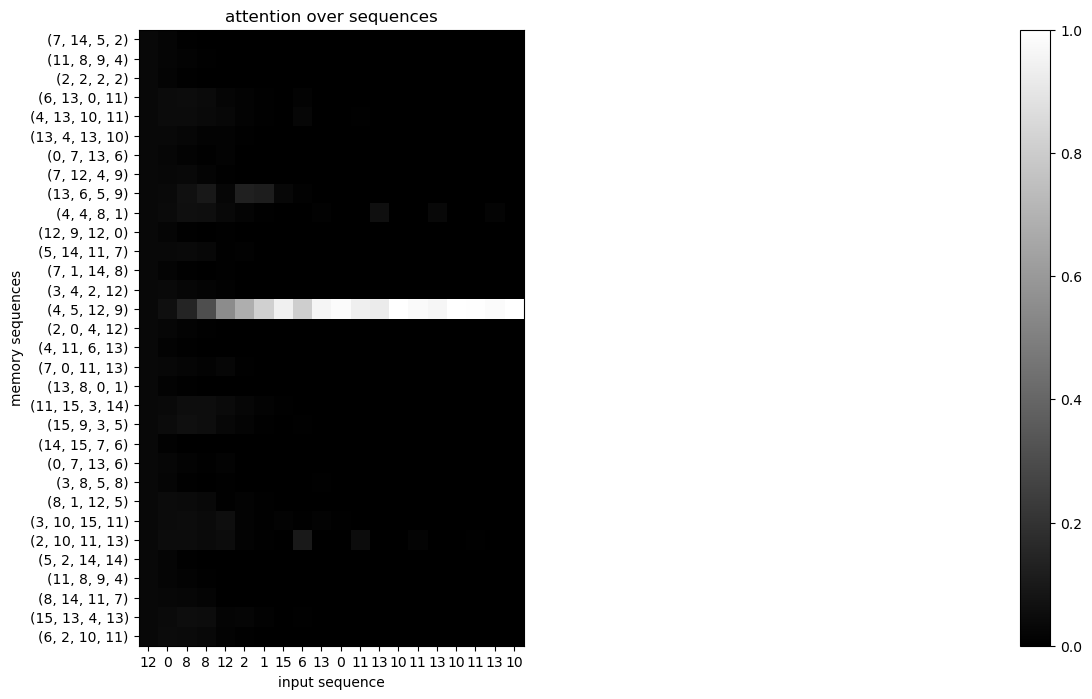

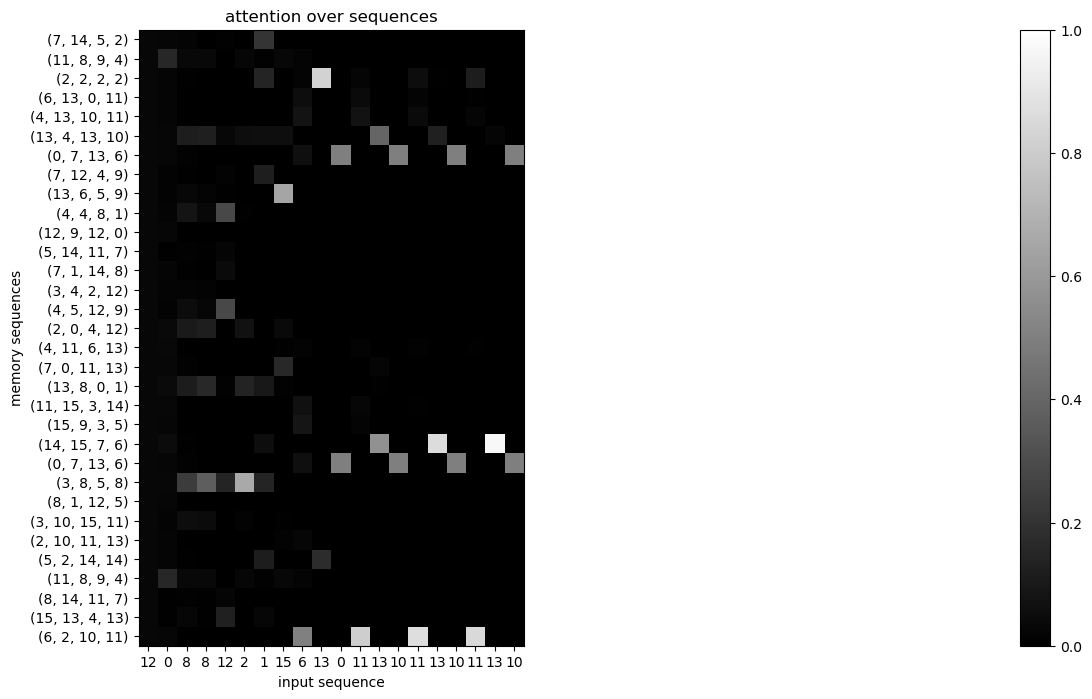

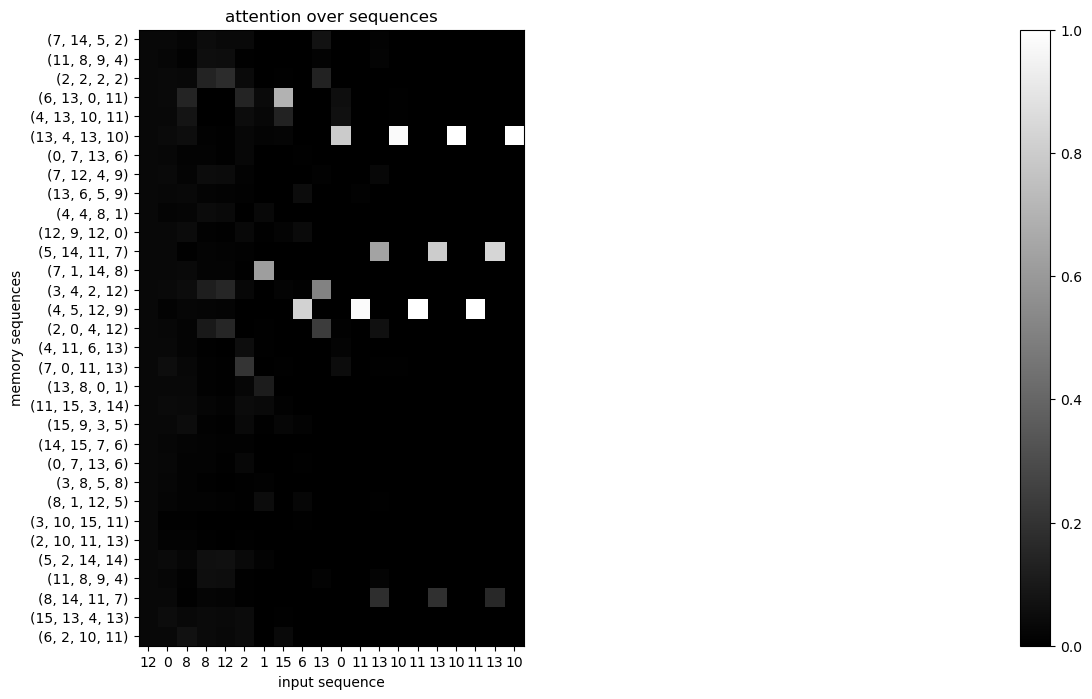

In [182]:
idx = 35
plot_attention(idx, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model1)
plot_attention(idx, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model2)
plot_attention(idx, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model3)
plot_attention(idx, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model4)
plot_attention(idx, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model5)

# memory 8 1 12 5 has high attention in the position later than it shows up in input sequence

# a lot of training input has no relevant memory, e.g. idx = 200


sample_input:  [[13  2  6  0 11 13 10 11 13 10 11 13 10 11 13 10 11 13 10 11]]
prediction: [10 13 13 11 13 10 11 13 10 11 13 10 11 13 10 11 13 10 11 13]
y: [ 2  6  0 11 13 10 11 13 10 11 13 10 11 13 10 11 13 10 11 13]
[False False False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
sample_input:  [[13  2  6  0 11 13 10 11 13 10 11 13 10 11 13 10 11 13 10 11]]
prediction: [ 3 11 13 11 13 10 11 13 10 11 13 10 11 13 10 11 13 10 11 13]
y: [ 2  6  0 11 13 10 11 13 10 11 13 10 11 13 10 11 13 10 11 13]
[False False False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
sample_input:  [[13  2  6  0 11 13 10 11 13 10 11 13 10 11 13 10 11 13 10 11]]
prediction: [ 6  6  0 11 13 10 11 13 10 11 13 10 11 13 10 11 13 10 11 13]
y: [ 2  6  0 11 13 10 11 13 10 11 13 10 11 13 10 11 13 10 11 13]
[False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  T

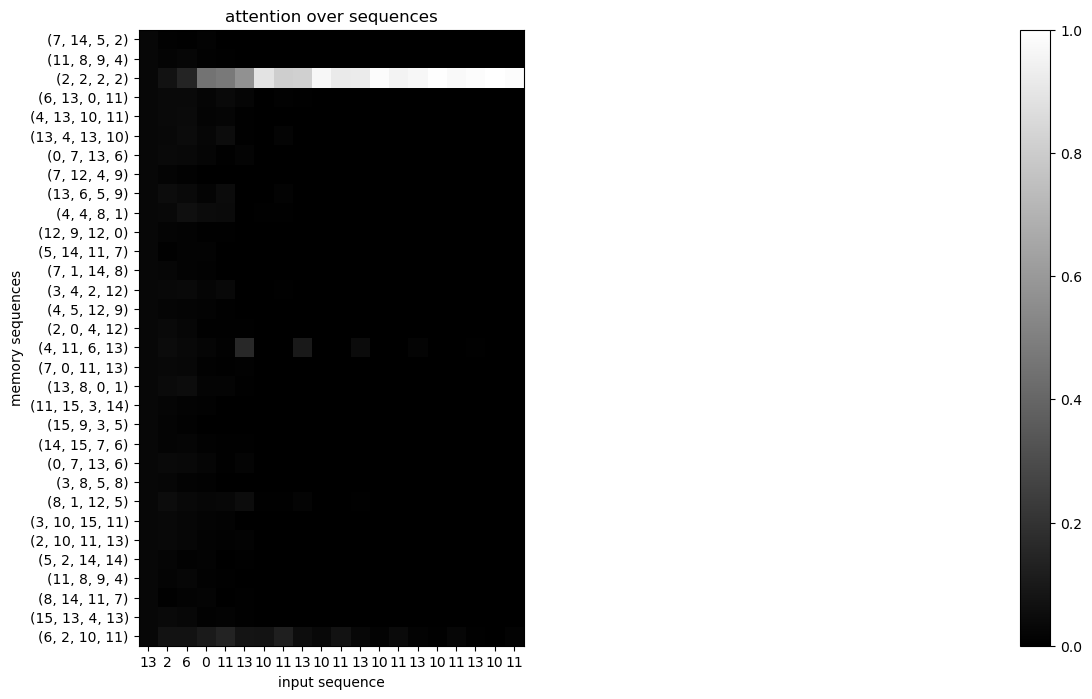

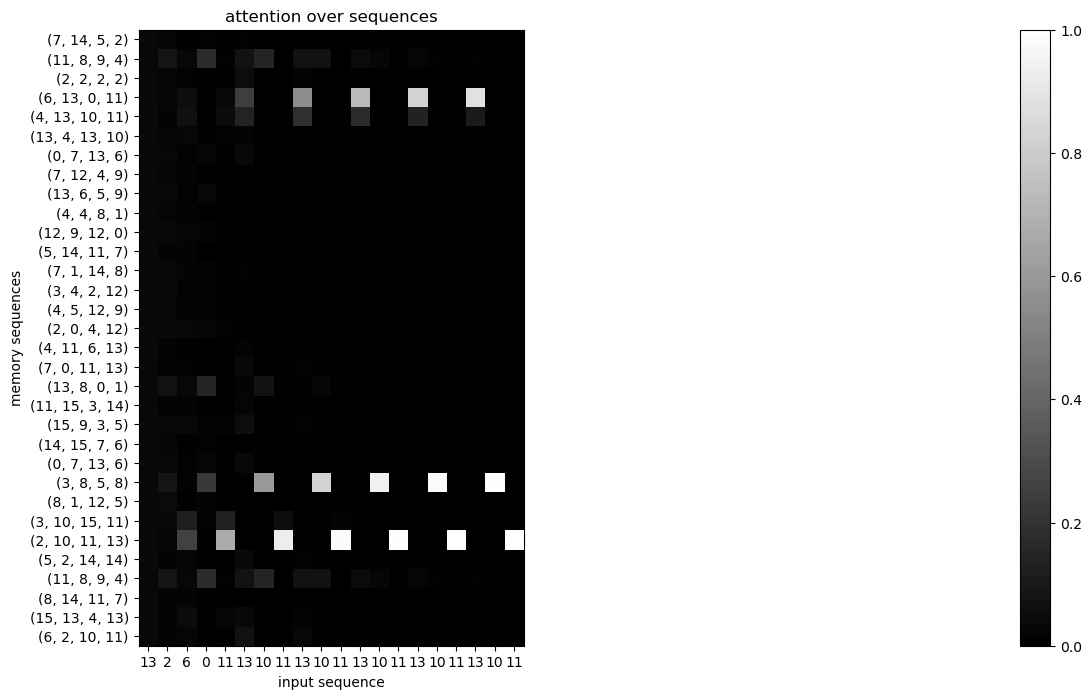

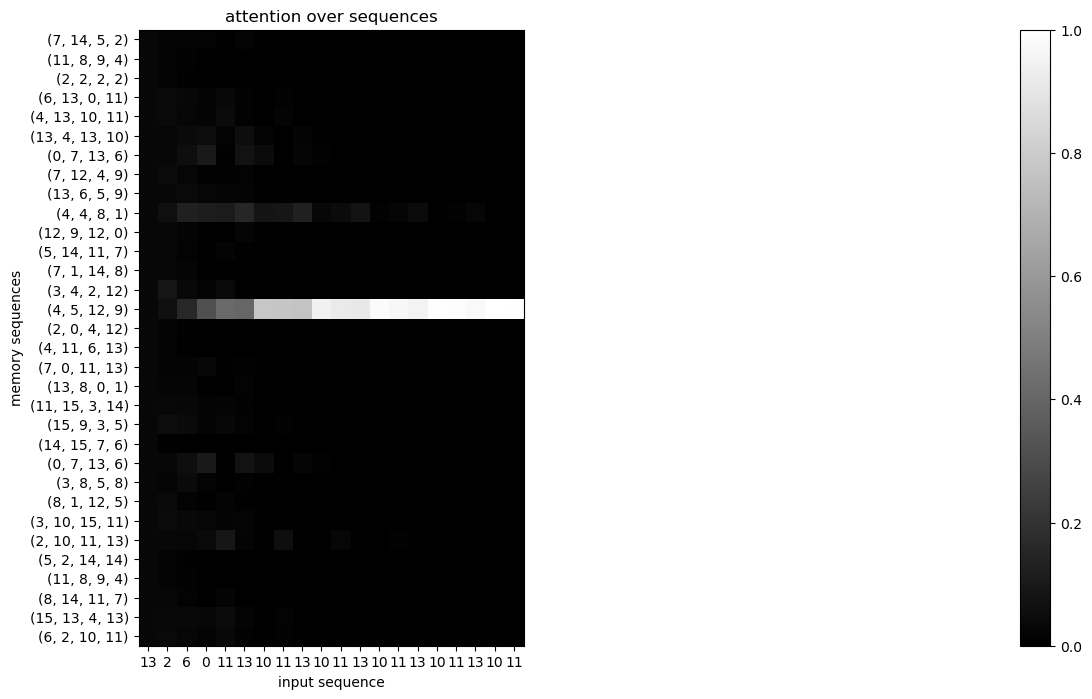

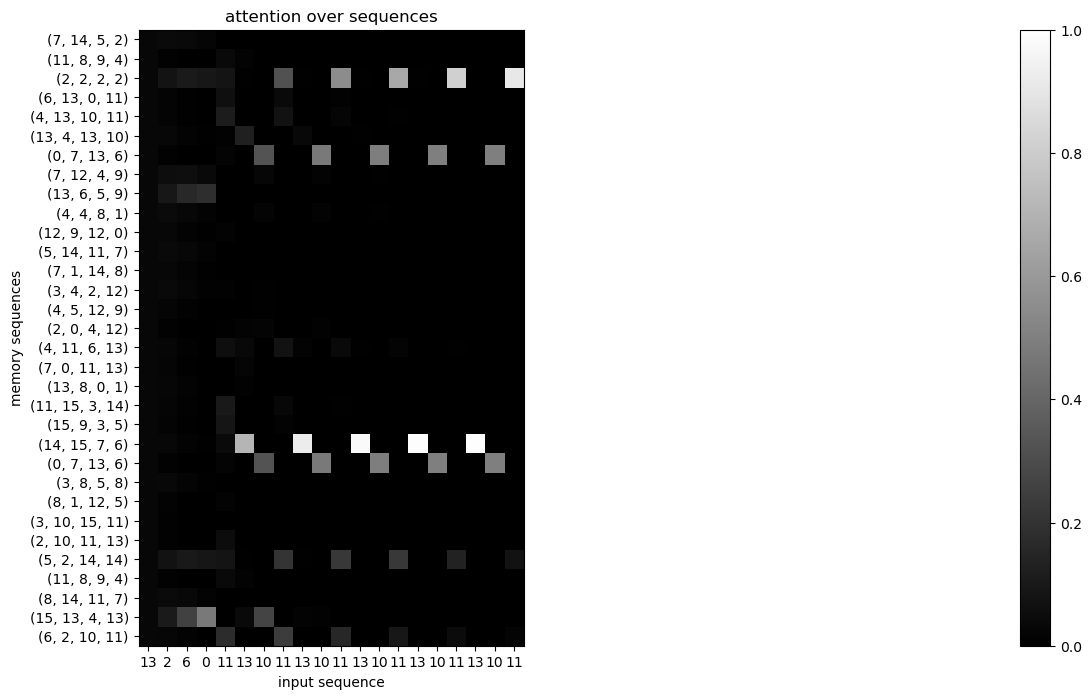

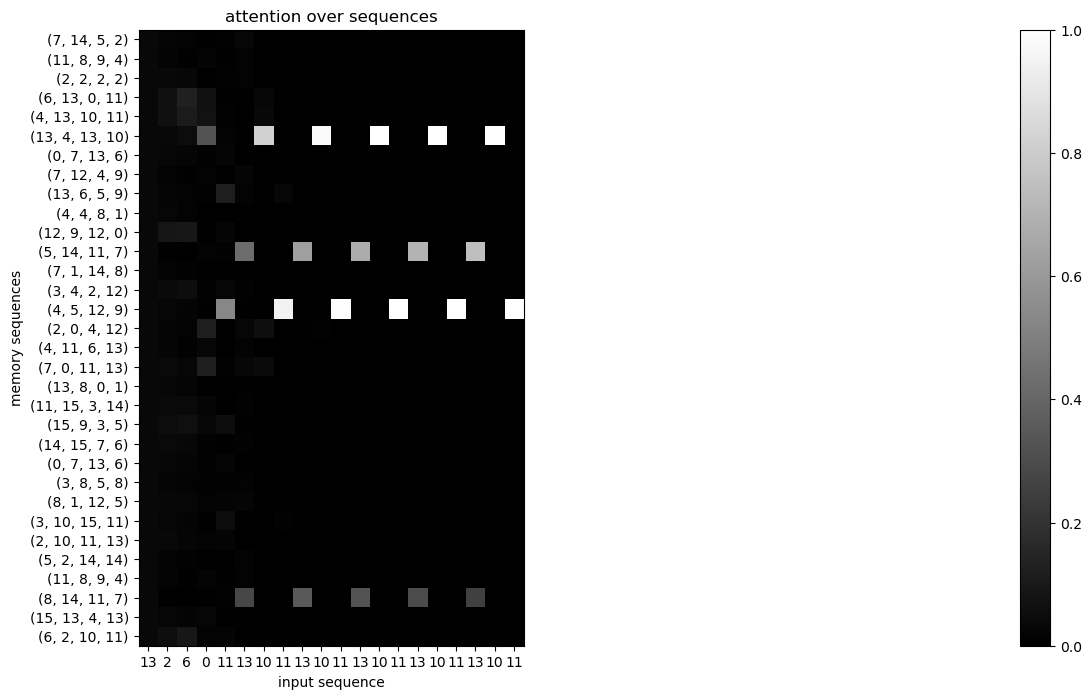

In [183]:
idx = 1

plot_attention(idx, seqs_x_test, seqs_y_test, mem_seqs_x_train, mem_seqs_y_train, memory_model1)
plot_attention(idx, seqs_x_test, seqs_y_test, mem_seqs_x_train, mem_seqs_y_train, memory_model2)
plot_attention(idx, seqs_x_test, seqs_y_test, mem_seqs_x_train, mem_seqs_y_train, memory_model3)
plot_attention(idx, seqs_x_test, seqs_y_test, mem_seqs_x_train, mem_seqs_y_train, memory_model4)
plot_attention(idx, seqs_x_test, seqs_y_test, mem_seqs_x_train, mem_seqs_y_train, memory_model5)

# capture the pattern

## Kernel Model 6, layernorm & normalize s.t. sum over vocab = 1, from_logits = False

In [191]:

from transformer_modules import AddPositionalEmbedding
import numpy as np
class MemoryModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, n_heads, **kwargs):
        super().__init__(**kwargs)

        self.alpha_it = None
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.pos_embedder_adder  = AddPositionalEmbedding(name='pos_embedder_adder')
        self.memory_pos_embedder_adder = MemoryAddPositionalEmbedding(name='mem_pos_embedder_adder')

        # different attention layers for input and memories
        self.self_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=embedding_dim//n_heads, value_dim=embedding_dim//n_heads, name='self_attn')
        self.memory_self_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=embedding_dim//n_heads, value_dim=embedding_dim//n_heads, name='mem_self_attn')
        
        # FF layer
        self.output_dense = layers.Dense(vocab_size, name='output')
       
        # create cross attention layer
        self.cross_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=key_dim, value_dim=embedding_dim//n_heads, name='cross_attn')
        
        # normalization
        self.layernorm = layers.LayerNormalization()

    def self_attention(self, seq):
        return self.self_attention_layer(seq, seq, use_causal_mask=True)

    def memory_self_attention(self, mem_seqs):
        lambda_fn = lambda x: self.memory_self_attention_layer(x, x, use_causal_mask=False)
        return tf.map_fn(lambda_fn, mem_seqs)

    def call(self, inputs):
        seq_input, memory_x_input, memory_y_input = inputs

        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_x_input)
        embedded_mem_y_seqs = self.embedder(memory_y_input)
        
        embedded_mem_x_seqs = self.memory_pos_embedder_adder(embedded_mem_x_seqs)
        embedded_mem_y_seqs = self.memory_pos_embedder_adder(embedded_mem_y_seqs)
       
        embedded_input_seqs = self.self_attention(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_self_attention(embedded_mem_x_seqs)
        # embedded_input_seqs.shape (batch_size, input_length, embedding_dim)
        # embedded_mem_x_seqs.shape (batch_size, num_memories, memory_length, embedding_dim)

        w_it_list = []
        logit_list = []
        # compute cross_attention_output here
        for t in range(embedded_mem_x_seqs.shape[1]):
            cross_attention_output = self.cross_attention_layer(
                query=embedded_input_seqs, 
                value=embedded_mem_y_seqs[:,t,:,:], 
                key=embedded_mem_x_seqs[:,t,:,:])
            # cross_attention_output.shape (batch_size, input_seq_length, embedding dim)

            # Compute logits from cross_attention_output
            # First Layer normalization here
            logits = self.layernorm(self.output_dense(cross_attention_output))
            
            logit_list.append(logits)
            sums = []
            for i in range(input_seq_len):
                sum_up_to_i = tf.reduce_sum(logits[:, :i, :], axis=1)
                sums.append(sum_up_to_i)
            # calc w_it for each t
            # to stack the results along the second dimension again
            w_it = tf.stack(sums, axis=1)  
            w_it_list.append(w_it)
        w_it_list = tf.stack(w_it_list, axis = 1)
        # w_it_list.shape （batch_size, num_memory, input_seq_length, vocab_size)

        logits_list = tf.stack(logit_list, axis = 1)
        # logits_list.shape （batch_size, num_memory, input_seq_length, vocab_size)
        
        alpha_it = tf.nn.softmax(w_it_list, axis=1)
        # alpha_it_list.shape （batch_size, num_memory, input_seq_length, vocab_size)
        
        self.alpha_it = alpha_it
        
        # Elementwise multiplication
        multiplied_tensor = alpha_it * tf.math.exp(logits_list)
    
        # Sum over t
        result = tf.reduce_sum(multiplied_tensor, axis=1)
        # tf.print(tf.reduce_sum(result, axis=2)) not sum to 1
        
        # Layer normalization here 
        result = result / (tf.reduce_sum(result, axis = 2)[:,:,np.newaxis])
        #tf.print(tf.reduce_sum(result, axis=2)) #should sum to 1 now
        # result.shape （batch_size, input_seq_length, vocab_size)
       
        return result

In [192]:
vocab_size = len(state_tuples)
embedding_dim = 64
memory_model6 = MemoryModel(
    vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim//4, n_heads=4, name='memory_model')

memory_model6([seqs_x_train[:64], mem_seqs_x_train[:64], mem_seqs_y_train[:64]]); # build model
create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
memory_model6.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
memory_model6.summary()

Model: "memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  16384     
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0 (unused)
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 self_attn (MultiHeadAttenti  multiple                 16640     
 on)                                                             
                                                                 
 mem_self_attn (MultiHeadAtt  multiple                 16640     
 ention)                                              







 88%|████████▊ | 88/100 [15:14:50<2:04:45, 623.75s/epoch, loss=4.43, accuracy=0]



















































































































































































































































































































































































































































































































































































































































































































































































































































































































































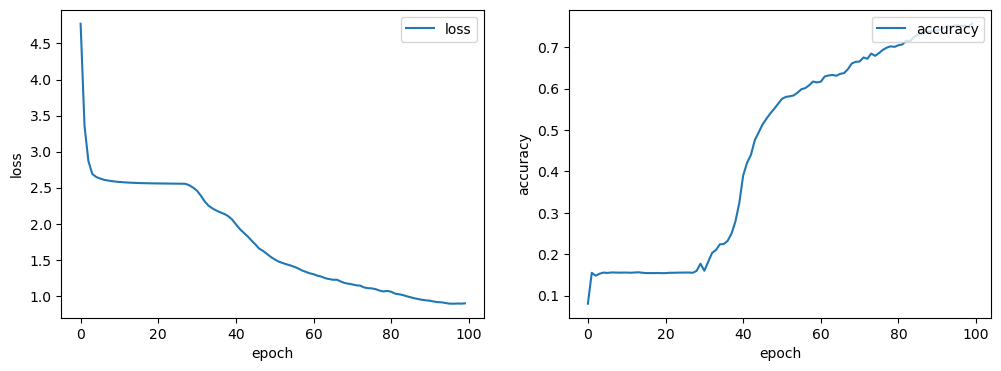

In [193]:
history6 = memory_model6.fit(train_ds, epochs=100, verbose=0, callbacks=[TqdmCallback()])
utils.plot_history(history6, plot_attrs=('loss', 'accuracy'), val=False, figsize=(12,4));

7/7 [==============================] - 1s 93ms/step


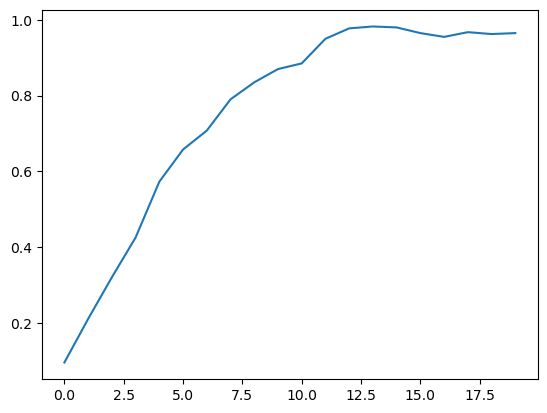

In [199]:
memory_model6.evaluate(train_ds)
memory_model6.evaluate(test_ds)

# plot accuracy as a function of position in sequence
preds6 = memory_model6.predict(train_ds)
preds6 = np.argmax(preds6, axis=-1)
acc_by_pos6 = np.mean(preds6 == seqs_y_train, axis=0)
plt.plot(acc_by_pos6)

### Attention analysis on model 6

sample_input:  [[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]]
prediction: [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
y: [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
sample_input:  [[ 2  9  0 15 12  2  1 15  6 13  0 11 13 10 11 13 10 11 13 10]]
prediction: [ 2  0 15 12  2  1 15  6 13  0 11 13 10 11 13 10 11 13 10 11]
y: [ 9  0 15 12  2  1 15  6 13  0 11 13 10 11 13 10 11 13 10 11]
[False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
sample_input:  [[ 9  7  1 14  8  1 12  5 14 11  7  7 12  4  9 14  0 15 12  2]]
prediction: [ 0  2  4  0  7  4  4 14  0  7 12 12  4  9 14  0 15 12  2  1]
y: [ 7  1 14  8  1 12  5 14 11  7  7 12  4  9 14  0 15 12  2  1]
[False False False False False False False  True False  True False  True
  True  True  True  True  True  True  True  True]
sample_input:  [[ 6  0 11 13 10 11 13

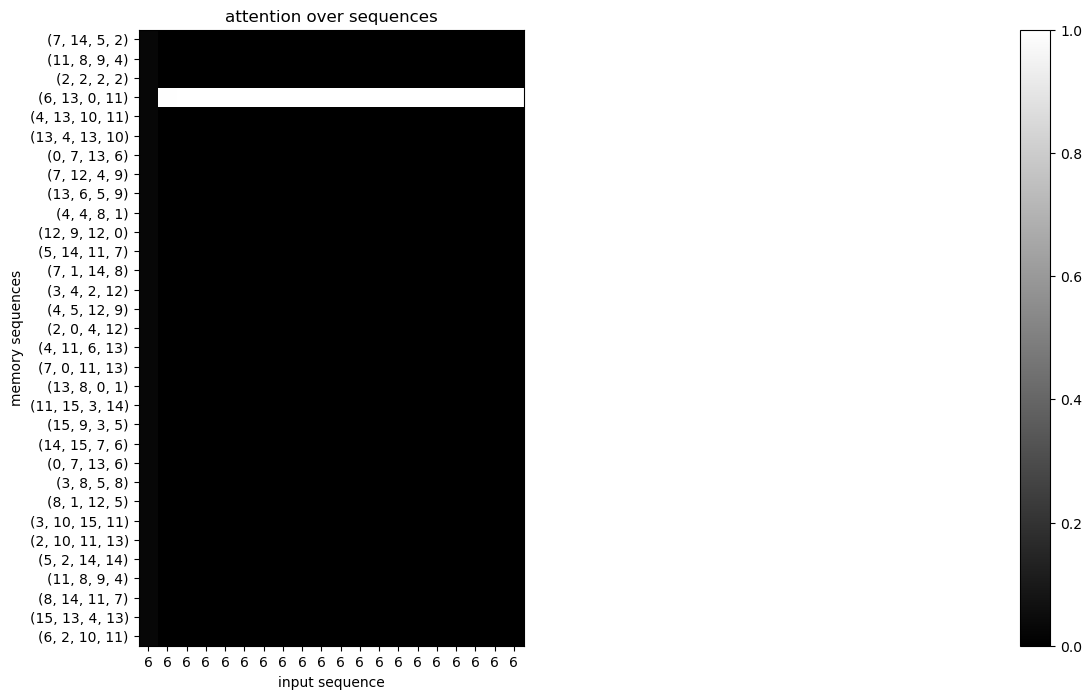

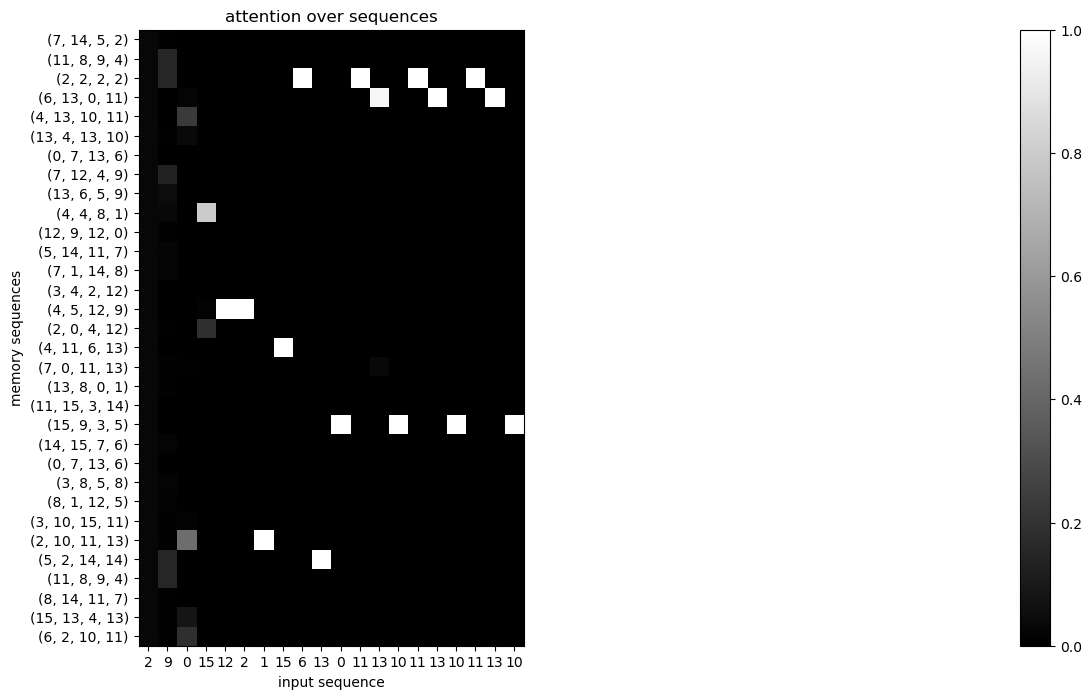

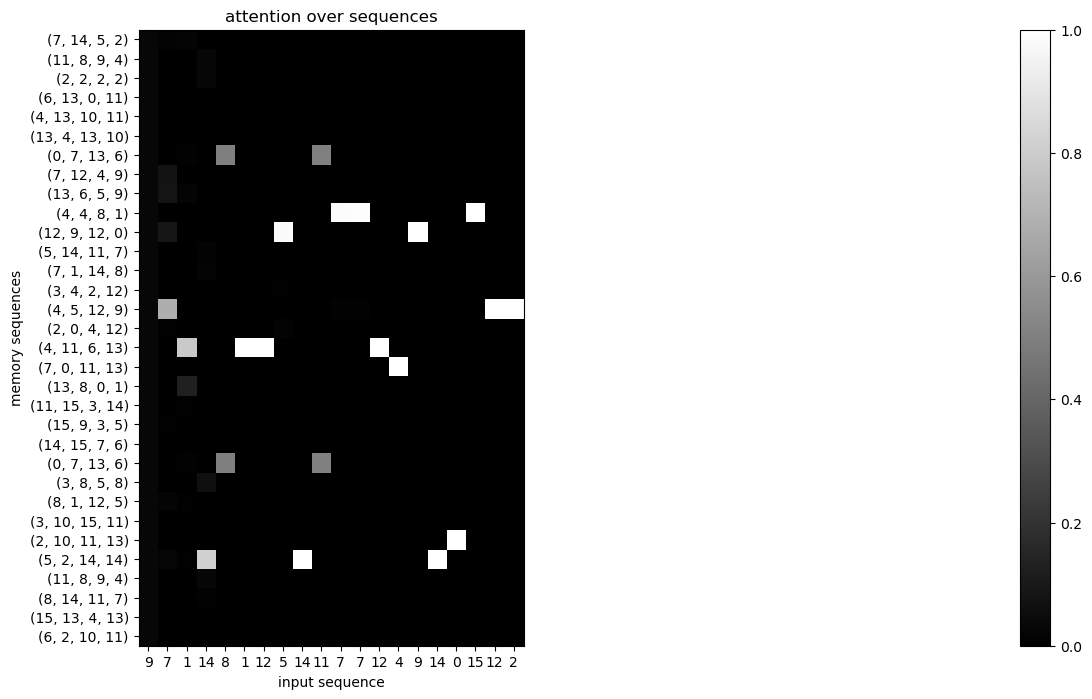

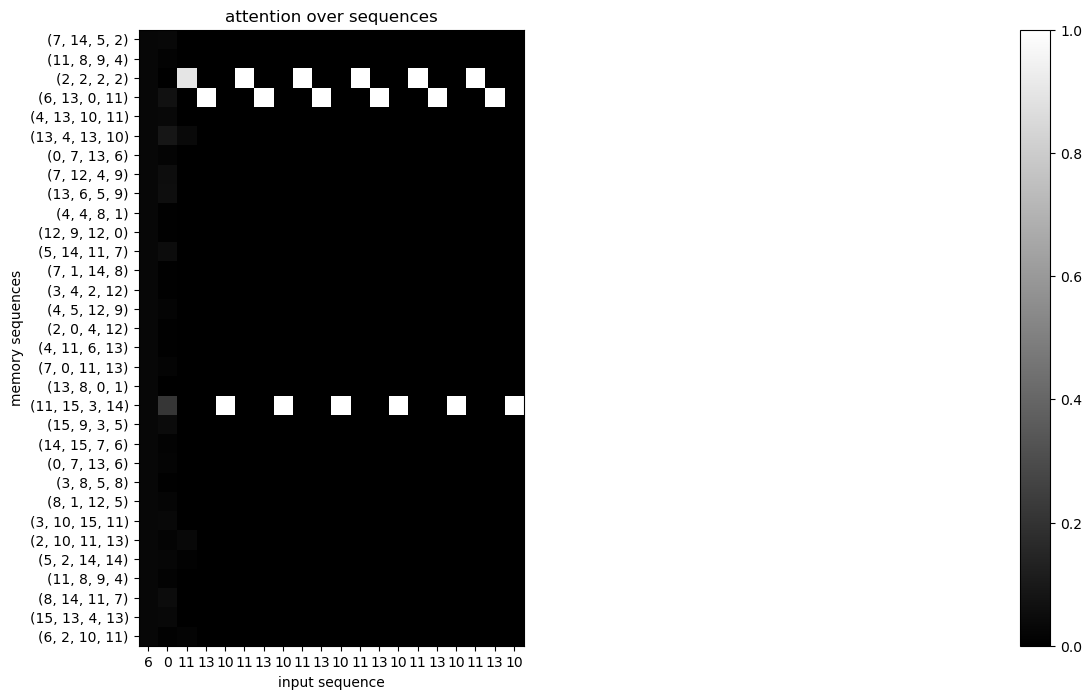

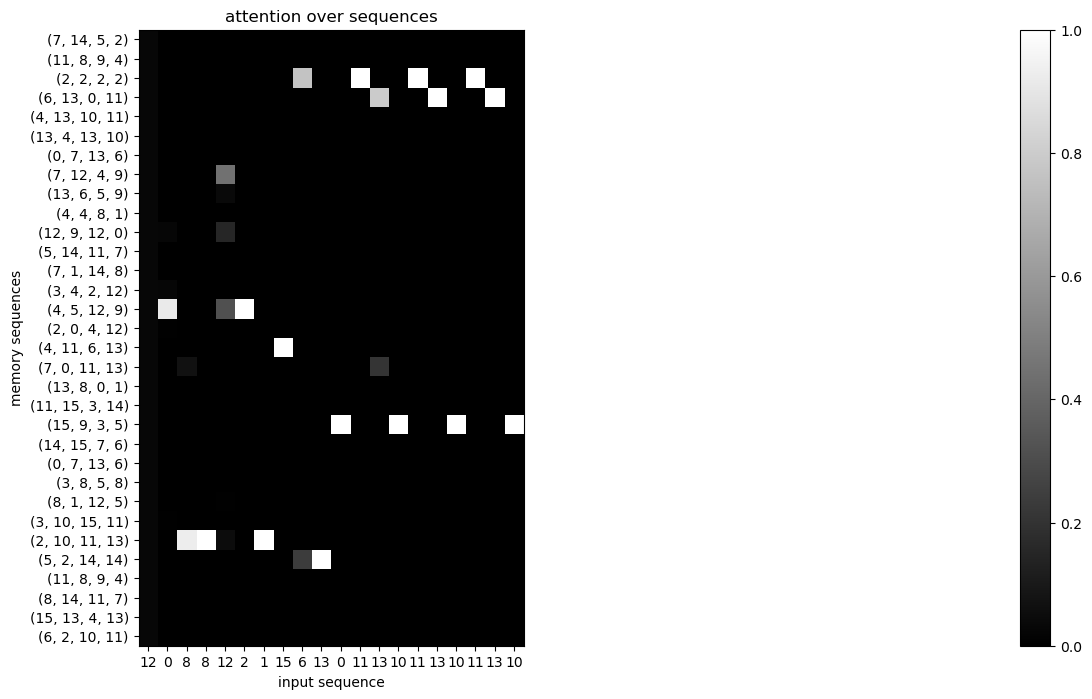

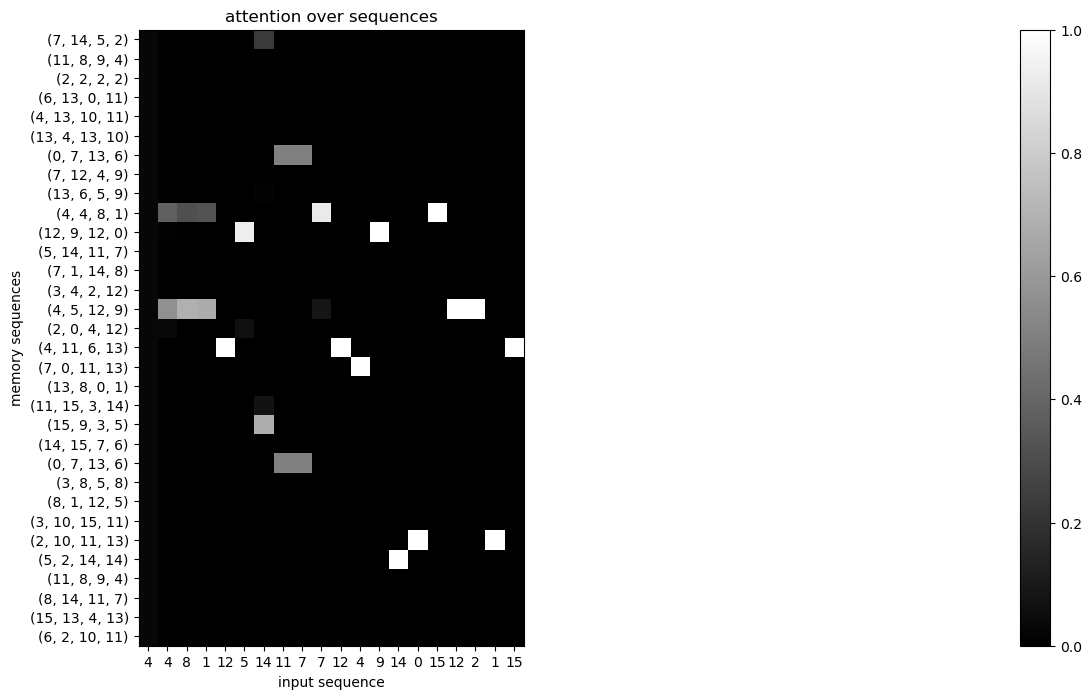

In [203]:
plot_attention(300, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model6)
plot_attention(1, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model6)
plot_attention(3, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model6)
plot_attention(100, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model6)
plot_attention(35, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model6)
plot_attention(2, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model6)


